In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v3_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-21 22:39:47.335168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 22:39:47.335803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 22:39:47.374560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 22:39:47.374929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 22:39:47.375132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_024'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_024
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

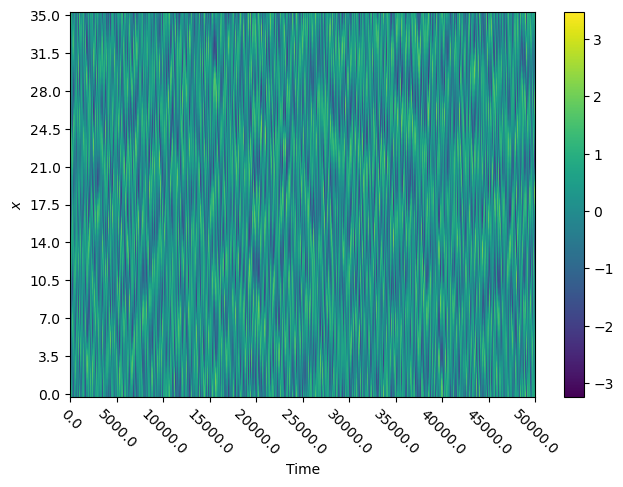

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

In [16]:
all_data.shape

(500026, 64)

# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 15])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [1e-5],
        [2e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.1198 - mse: 0.0111 - NMSE: 0.0997 - covmat_fro_loss: 0.0015 - global_gradnorm: 2.1554 - tot_time: 0h 0m 12.6s

Epoch 1: val_NMSE improved from inf to 0.02263, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/L

Epoch 11/1000
76/76 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 4.5514e-04 - global_gradnorm: 1.0192 - tot_time: 0h 1m 1.4s

Epoch 11: val_NMSE improved from 0.01528 to 0.01512, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0395 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 4.5480e-04 - global_gradnorm: 1.0207 - val_loss: 0.0396 - val_mse: 0.0017 - val_NMSE: 0.0151 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0392 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 4.5111e-04 - global_gradnorm: 1.0281 - tot_time: 0h 1m 6.5s

Epoch 12: val_NMSE did not i

Epoch 22/1000
76/76 [==============================] - ETA: 0s - loss: 0.0356 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 3.9840e-04 - global_gradnorm: 0.8657 - tot_time: 0h 1m 59.1s

Epoch 22: val_NMSE improved from 0.01216 to 0.01200, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0356 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 3.9864e-04 - global_gradnorm: 0.8665 - val_loss: 0.0363 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0354 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 3.9640e-04 - global_gradnorm: 0.8990 - tot_time: 0h 2m 3.8s

Epoch 23: val_NMSE improved

Epoch 33/1000
76/76 [==============================] - ETA: 0s - loss: 0.0329 - mse: 9.8398e-04 - NMSE: 0.0089 - covmat_fro_loss: 3.5785e-04 - global_gradnorm: 0.8273 - tot_time: 0h 2m 55.4s

Epoch 33: val_NMSE improved from 0.00962 to 0.00949, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 65ms/step - loss: 0.0329 - mse: 9.8398e-04 - NMSE: 0.0089 - covmat_fro_loss: 3.5790e-04 - global_gradnorm: 0.8276 - val_loss: 0.0335 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/1000
76/76 [==============================] - ETA: 0s - loss: 0.0327 - mse: 9.5536e-04 - NMSE: 0.0086 - covmat_fro_loss: 3.5269e-04 - global_gradnorm: 0.7568 - tot_time: 0h 3m 0.6s

Epoch 34: val_N

Epoch 44/1000
76/76 [==============================] - ETA: 0s - loss: 0.0311 - mse: 8.1055e-04 - NMSE: 0.0073 - covmat_fro_loss: 3.2741e-04 - global_gradnorm: 0.7529 - tot_time: 0h 3m 51.6s

Epoch 44: val_NMSE improved from 0.00808 to 0.00798, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0311 - mse: 8.1055e-04 - NMSE: 0.0073 - covmat_fro_loss: 3.2746e-04 - global_gradnorm: 0.7549 - val_loss: 0.0317 - val_mse: 8.8625e-04 - val_NMSE: 0.0080 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/1000
76/76 [==============================] - ETA: 0s - loss: 0.0310 - mse: 8.0236e-04 - NMSE: 0.0072 - covmat_fro_loss: 3.2647e-04 - global_gradnorm: 0.7482 - tot_time: 0h 3m 56.1s

Epoch 45: 

76/76 [==============================] - ETA: 0s - loss: 0.0297 - mse: 6.9848e-04 - NMSE: 0.0063 - covmat_fro_loss: 3.0608e-04 - global_gradnorm: 0.6967 - tot_time: 0h 4m 42.6s

Epoch 55: val_NMSE improved from 0.00709 to 0.00704, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0297 - mse: 6.9848e-04 - NMSE: 0.0063 - covmat_fro_loss: 3.0635e-04 - global_gradnorm: 0.6980 - val_loss: 0.0304 - val_mse: 7.8271e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 56/1000
76/76 [==============================] - ETA: 0s - loss: 0.0296 - mse: 6.9522e-04 - NMSE: 0.0063 - covmat_fro_loss: 3.0516e-04 - global_gradnorm: 0.7018 - tot_time: 0h 4m 48.2s

Epoch 56: val_NMSE impro

76/76 [==============================] - ETA: 0s - loss: 0.0287 - mse: 6.2826e-04 - NMSE: 0.0057 - covmat_fro_loss: 2.9160e-04 - global_gradnorm: 0.6695 - tot_time: 0h 5m 42.2s

Epoch 66: val_NMSE did not improve from 0.00630
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0287 - mse: 6.2826e-04 - NMSE: 0.0057 - covmat_fro_loss: 2.9169e-04 - global_gradnorm: 0.6687 - val_loss: 0.0294 - val_mse: 7.1599e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 67/1000
76/76 [==============================] - ETA: 0s - loss: 0.0286 - mse: 6.2364e-04 - NMSE: 0.0056 - covmat_fro_loss: 2.9099e-04 - global_gradnorm: 0.6685 - tot_time: 0h 5m 47.6s

Epoch 67: val_NMSE improved from 0.00630 to 0.00623, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoint

Epoch 78/1000
76/76 [==============================] - ETA: 0s - loss: 0.0276 - mse: 5.5211e-04 - NMSE: 0.0050 - covmat_fro_loss: 2.7483e-04 - global_gradnorm: 0.5751 - tot_time: 0h 6m 46.2s

Epoch 78: val_NMSE improved from 0.00584 to 0.00581, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0276 - mse: 5.5211e-04 - NMSE: 0.0050 - covmat_fro_loss: 2.7471e-04 - global_gradnorm: 0.5744 - val_loss: 0.0284 - val_mse: 6.4553e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 79/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0277 - mse: 5.6823e-04 - NMSE: 0.0051 - covmat_fro_loss: 2.7861e-04 - global_gradnorm: 0.6407 - tot_time: 0h 6m 51.1s

Epoch 79: 

76/76 [==============================] - ETA: 0s - loss: 0.0270 - mse: 5.2318e-04 - NMSE: 0.0047 - covmat_fro_loss: 2.6794e-04 - global_gradnorm: 0.5975 - tot_time: 0h 7m 45.9s

Epoch 89: val_NMSE improved from 0.00537 to 0.00535, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 74ms/step - loss: 0.0270 - mse: 5.2318e-04 - NMSE: 0.0047 - covmat_fro_loss: 2.6787e-04 - global_gradnorm: 0.5969 - val_loss: 0.0276 - val_mse: 5.9462e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 90/1000
76/76 [==============================] - ETA: 0s - loss: 0.0269 - mse: 5.1428e-04 - NMSE: 0.0046 - covmat_fro_loss: 2.6545e-04 - global_gradnorm: 0.5614 - tot_time: 0h 7m 51.4s

Epoch 90: val_NMSE did n

Epoch 100/1000
76/76 [==============================] - ETA: 0s - loss: 0.0262 - mse: 4.7758e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5687e-04 - global_gradnorm: 0.5390 - tot_time: 0h 8m 46.0s

Epoch 100: val_NMSE improved from 0.00502 to 0.00501, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 74ms/step - loss: 0.0262 - mse: 4.7758e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5693e-04 - global_gradnorm: 0.5404 - val_loss: 0.0268 - val_mse: 5.5708e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 101/1000
76/76 [==============================] - ETA: 0s - loss: 0.0261 - mse: 4.7601e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5637e-04 - global_gradnorm: 0.5249 - tot_time: 0h 8m 51.6s

Epoch 1

Epoch 112/1000
76/76 [==============================] - ETA: 0s - loss: 0.0255 - mse: 4.4848e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4962e-04 - global_gradnorm: 0.5110 - tot_time: 0h 9m 51.2s

Epoch 112: val_NMSE improved from 0.00478 to 0.00464, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0255 - mse: 4.4848e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4959e-04 - global_gradnorm: 0.5094 - val_loss: 0.0261 - val_mse: 5.1589e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 113/1000
76/76 [==============================] - ETA: 0s - loss: 0.0255 - mse: 4.5193e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5083e-04 - global_gradnorm: 0.5342 - tot_time: 0h 9m 57.1s

Epoch 1

Epoch 124/1000
76/76 [==============================] - ETA: 0s - loss: 0.0248 - mse: 4.1720e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.4137e-04 - global_gradnorm: 0.4735 - tot_time: 0h 10m 56.1s

Epoch 124: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0248 - mse: 4.1720e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.4153e-04 - global_gradnorm: 0.4743 - val_loss: 0.0255 - val_mse: 4.9566e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 125/1000
76/76 [==============================] - ETA: 0s - loss: 0.0248 - mse: 4.1548e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.4107e-04 - global_gradnorm: 0.4802 - tot_time: 0h 11m 1.3s

Epoch 125: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

76/76 [==============================] - ETA: 0s - loss: 0.0243 - mse: 3.9650e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3578e-04 - global_gradnorm: 0.4656 - tot_time: 0h 11m 56.1s

Epoch 135: val_NMSE did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 73ms/step - loss: 0.0243 - mse: 3.9650e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3567e-04 - global_gradnorm: 0.4647 - val_loss: 0.0248 - val_mse: 4.6772e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 136/1000
76/76 [==============================] - ETA: 0s - loss: 0.0242 - mse: 3.9137e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3443e-04 - global_gradnorm: 0.4363 - tot_time: 0h 12m 1.2s

Epoch 136: val_NMSE improved from 0.00414 to 0.00411, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkp

Epoch 147/1000
76/76 [==============================] - ETA: 0s - loss: 0.0237 - mse: 3.7501e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2986e-04 - global_gradnorm: 0.4484 - tot_time: 0h 13m 0.5s

Epoch 147: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 72ms/step - loss: 0.0237 - mse: 3.7501e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2987e-04 - global_gradnorm: 0.4492 - val_loss: 0.0242 - val_mse: 4.4239e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 148/1000
76/76 [==============================] - ETA: 0s - loss: 0.0236 - mse: 3.7114e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2904e-04 - global_gradnorm: 0.4266 - tot_time: 0h 13m 5.7s

Epoch 148: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 159/1000
76/76 [==============================] - ETA: 0s - loss: 0.0231 - mse: 3.5239e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2350e-04 - global_gradnorm: 0.4056 - tot_time: 0h 14m 6.6s

Epoch 159: val_NMSE improved from 0.00383 to 0.00383, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0231 - mse: 3.5239e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2345e-04 - global_gradnorm: 0.4054 - val_loss: 0.0237 - val_mse: 4.2544e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 160/1000
76/76 [==============================] - ETA: 0s - loss: 0.0230 - mse: 3.5502e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2433e-04 - global_gradnorm: 0.4325 - tot_time: 0h 14m 12.2s

Epoch 

Epoch 171/1000
76/76 [==============================] - ETA: 0s - loss: 0.0225 - mse: 3.3852e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1932e-04 - global_gradnorm: 0.3964 - tot_time: 0h 15m 11.2s

Epoch 171: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0225 - mse: 3.3852e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1933e-04 - global_gradnorm: 0.3980 - val_loss: 0.0231 - val_mse: 4.1034e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 172/1000
76/76 [==============================] - ETA: 0s - loss: 0.0225 - mse: 3.3729e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1911e-04 - global_gradnorm: 0.3910 - tot_time: 0h 15m 16.6s

Epoch 172: val_NMSE improved from 0.00362 to 0.00357, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 183/1000
76/76 [==============================] - ETA: 0s - loss: 0.0220 - mse: 3.2183e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1417e-04 - global_gradnorm: 0.3683 - tot_time: 0h 16m 12.6s

Epoch 183: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0220 - mse: 3.2183e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1407e-04 - global_gradnorm: 0.3691 - val_loss: 0.0226 - val_mse: 3.9560e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 184/1000
76/76 [==============================] - ETA: 0s - loss: 0.0219 - mse: 3.2156e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1391e-04 - global_gradnorm: 0.3617 - tot_time: 0h 16m 17.9s

Epoch 184: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 195/1000
76/76 [==============================] - ETA: 0s - loss: 0.0215 - mse: 3.1165e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1116e-04 - global_gradnorm: 0.3527 - tot_time: 0h 17m 15.2s

Epoch 195: val_NMSE did not improve from 0.00334
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0215 - mse: 3.1165e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1147e-04 - global_gradnorm: 0.3536 - val_loss: 0.0220 - val_mse: 3.8126e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 196/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0214 - mse: 3.0975e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1049e-04 - global_gradnorm: 0.3512 - tot_time: 0h 17m 20.2s

Epoch 196: val_NMSE did not improve from 0.00334
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 207/1000
76/76 [==============================] - ETA: 0s - loss: 0.0210 - mse: 2.9974e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0716e-04 - global_gradnorm: 0.3565 - tot_time: 0h 18m 13.8s

Epoch 207: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 72ms/step - loss: 0.0210 - mse: 2.9974e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0739e-04 - global_gradnorm: 0.3569 - val_loss: 0.0216 - val_mse: 3.7198e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 208/1000
76/76 [==============================] - ETA: 0s - loss: 0.0210 - mse: 3.0213e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0784e-04 - global_gradnorm: 0.3628 - tot_time: 0h 18m 18.9s

Epoch 208: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 219/1000
76/76 [==============================] - ETA: 0s - loss: 0.0205 - mse: 2.8764e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0331e-04 - global_gradnorm: 0.3219 - tot_time: 0h 19m 15.6s

Epoch 219: val_NMSE did not improve from 0.00322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0205 - mse: 2.8764e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0337e-04 - global_gradnorm: 0.3224 - val_loss: 0.0211 - val_mse: 3.6275e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 220/1000
76/76 [==============================] - ETA: 0s - loss: 0.0205 - mse: 2.9073e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0442e-04 - global_gradnorm: 0.3353 - tot_time: 0h 19m 20.5s

Epoch 220: val_NMSE improved from 0.00322 to 0.00314, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 231/1000
76/76 [==============================] - ETA: 0s - loss: 0.0201 - mse: 2.8889e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0351e-04 - global_gradnorm: 0.3477 - tot_time: 0h 20m 18.0s

Epoch 231: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0201 - mse: 2.8889e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0351e-04 - global_gradnorm: 0.3473 - val_loss: 0.0206 - val_mse: 3.5085e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 232/1000
76/76 [==============================] - ETA: 0s - loss: 0.0200 - mse: 2.8438e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0213e-04 - global_gradnorm: 0.3249 - tot_time: 0h 20m 23.0s

Epoch 232: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 243/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - mse: 2.8064e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0095e-04 - global_gradnorm: 0.3264 - tot_time: 0h 21m 19.2s

Epoch 243: val_NMSE improved from 0.00305 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0196 - mse: 2.8064e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0103e-04 - global_gradnorm: 0.3258 - val_loss: 0.0201 - val_mse: 3.3907e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 244/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - mse: 2.7788e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0009e-04 - global_gradnorm: 0.3198 - tot_time: 0h 21m 24.6s

Epoch

Epoch 255/1000
76/76 [==============================] - ETA: 0s - loss: 0.0192 - mse: 2.7193e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9811e-04 - global_gradnorm: 0.3223 - tot_time: 0h 22m 19.8s

Epoch 255: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 63ms/step - loss: 0.0192 - mse: 2.7193e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9811e-04 - global_gradnorm: 0.3221 - val_loss: 0.0197 - val_mse: 3.3940e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 256/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 2.7343e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9842e-04 - global_gradnorm: 0.3295 - tot_time: 0h 22m 25.1s

Epoch 256: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 267/1000
76/76 [==============================] - ETA: 0s - loss: 0.0188 - mse: 2.7025e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9741e-04 - global_gradnorm: 0.3191 - tot_time: 0h 23m 20.6s

Epoch 267: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0188 - mse: 2.7025e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9734e-04 - global_gradnorm: 0.3184 - val_loss: 0.0194 - val_mse: 3.4814e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 268/1000
76/76 [==============================] - ETA: 0s - loss: 0.0188 - mse: 2.7148e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9787e-04 - global_gradnorm: 0.3283 - tot_time: 0h 23m 25.6s

Epoch 268: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 279/1000
76/76 [==============================] - ETA: 0s - loss: 0.0184 - mse: 2.6889e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9716e-04 - global_gradnorm: 0.3366 - tot_time: 0h 24m 21.0s

Epoch 279: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 62ms/step - loss: 0.0184 - mse: 2.6889e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9707e-04 - global_gradnorm: 0.3368 - val_loss: 0.0189 - val_mse: 3.2467e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 280/1000
76/76 [==============================] - ETA: 0s - loss: 0.0183 - mse: 2.6015e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9397e-04 - global_gradnorm: 0.2999 - tot_time: 0h 24m 26.2s

Epoch 280: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 291/1000
76/76 [==============================] - ETA: 0s - loss: 0.0180 - mse: 2.5965e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9352e-04 - global_gradnorm: 0.3108 - tot_time: 0h 25m 23.8s

Epoch 291: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0180 - mse: 2.5965e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9349e-04 - global_gradnorm: 0.3109 - val_loss: 0.0185 - val_mse: 3.2465e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 292/1000
76/76 [==============================] - ETA: 0s - loss: 0.0180 - mse: 2.6067e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9447e-04 - global_gradnorm: 0.3115 - tot_time: 0h 25m 29.1s

Epoch 292: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 303/1000
76/76 [==============================] - ETA: 0s - loss: 0.0176 - mse: 2.5666e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9277e-04 - global_gradnorm: 0.3048 - tot_time: 0h 26m 25.3s

Epoch 303: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0176 - mse: 2.5666e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9275e-04 - global_gradnorm: 0.3045 - val_loss: 0.0182 - val_mse: 3.1922e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 304/1000
76/76 [==============================] - ETA: 0s - loss: 0.0176 - mse: 2.5846e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9316e-04 - global_gradnorm: 0.3309 - tot_time: 0h 26m 30.6s

Epoch 304: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 315/1000
76/76 [==============================] - ETA: 0s - loss: 0.0173 - mse: 2.5676e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9291e-04 - global_gradnorm: 0.3233 - tot_time: 0h 27m 27.8s

Epoch 315: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0173 - mse: 2.5676e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9289e-04 - global_gradnorm: 0.3229 - val_loss: 0.0178 - val_mse: 3.1682e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 316/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 2.4980e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9057e-04 - global_gradnorm: 0.2959 - tot_time: 0h 27m 33.1s

Epoch 316: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 327/1000
76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 2.5211e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9107e-04 - global_gradnorm: 0.3206 - tot_time: 0h 28m 33.3s

Epoch 327: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 72ms/step - loss: 0.0169 - mse: 2.5211e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9117e-04 - global_gradnorm: 0.3209 - val_loss: 0.0175 - val_mse: 3.2023e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 328/1000
76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 2.5322e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9160e-04 - global_gradnorm: 0.3210 - tot_time: 0h 28m 39.0s

Epoch 328: val_NMSE did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 339/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0166 - mse: 2.4647e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8917e-04 - global_gradnorm: 0.3068 - tot_time: 0h 29m 39.1s

Epoch 339: val_NMSE improved from 0.00275 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0166 - mse: 2.4651e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8917e-04 - global_gradnorm: 0.3079 - val_loss: 0.0170 - val_mse: 3.0404e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 340/1000
76/76 [==============================] - ETA: 0s - loss: 0.0166 - mse: 2.4743e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8962e-04 - global_gradnorm: 0.3118 - tot_time: 0h 29m 44.4s

Epoch

Epoch 351/1000
76/76 [==============================] - ETA: 0s - loss: 0.0163 - mse: 2.4593e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8872e-04 - global_gradnorm: 0.3142 - tot_time: 0h 30m 45.5s

Epoch 351: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0163 - mse: 2.4593e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8866e-04 - global_gradnorm: 0.3140 - val_loss: 0.0167 - val_mse: 3.0525e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 352/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 2.4076e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8701e-04 - global_gradnorm: 0.2990 - tot_time: 0h 30m 50.9s

Epoch 352: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 363/1000
76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 2.4160e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8722e-04 - global_gradnorm: 0.2975 - tot_time: 0h 31m 51.6s

Epoch 363: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 71ms/step - loss: 0.0159 - mse: 2.4160e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8722e-04 - global_gradnorm: 0.2976 - val_loss: 0.0164 - val_mse: 3.0158e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 364/1000
76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 2.3774e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8609e-04 - global_gradnorm: 0.2876 - tot_time: 0h 31m 56.9s

Epoch 364: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 375/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 2.3488e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8503e-04 - global_gradnorm: 0.2865 - tot_time: 0h 32m 56.7s

Epoch 375: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0156 - mse: 2.3488e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8512e-04 - global_gradnorm: 0.2863 - val_loss: 0.0161 - val_mse: 2.9956e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 376/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 2.4182e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8755e-04 - global_gradnorm: 0.3060 - tot_time: 0h 33m 1.4s

Epoch 376: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 387/1000
76/76 [==============================] - ETA: 0s - loss: 0.0153 - mse: 2.3699e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8560e-04 - global_gradnorm: 0.3094 - tot_time: 0h 33m 56.4s

Epoch 387: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 73ms/step - loss: 0.0153 - mse: 2.3699e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8558e-04 - global_gradnorm: 0.3100 - val_loss: 0.0158 - val_mse: 3.0194e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 388/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0153 - mse: 2.3520e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8524e-04 - global_gradnorm: 0.2945 - tot_time: 0h 34m 1.8s

Epoch 388: val_NMSE improved from 0.00266 to 0.00265, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR

Epoch 399/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0150 - mse: 2.3143e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8372e-04 - global_gradnorm: 0.2893 - tot_time: 0h 35m 0.1s

Epoch 399: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0150 - mse: 2.3168e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8392e-04 - global_gradnorm: 0.2898 - val_loss: 0.0156 - val_mse: 3.0173e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 400/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.3512e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8500e-04 - global_gradnorm: 0.3067 - tot_time: 0h 35m 5.4s

Epoch 400: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 411/1000
76/76 [==============================] - ETA: 0s - loss: 0.0147 - mse: 2.3032e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8316e-04 - global_gradnorm: 0.2986 - tot_time: 0h 36m 5.1s

Epoch 411: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0147 - mse: 2.3032e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8297e-04 - global_gradnorm: 0.2982 - val_loss: 0.0152 - val_mse: 2.9077e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 412/1000
76/76 [==============================] - ETA: 0s - loss: 0.0147 - mse: 2.2940e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8294e-04 - global_gradnorm: 0.2991 - tot_time: 0h 36m 10.3s

Epoch 412: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 423/1000
76/76 [==============================] - ETA: 0s - loss: 0.0144 - mse: 2.2510e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8129e-04 - global_gradnorm: 0.2790 - tot_time: 0h 37m 10.2s

Epoch 423: val_NMSE did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 71ms/step - loss: 0.0144 - mse: 2.2510e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8138e-04 - global_gradnorm: 0.2792 - val_loss: 0.0150 - val_mse: 2.9559e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 424/1000
76/76 [==============================] - ETA: 0s - loss: 0.0144 - mse: 2.2630e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8182e-04 - global_gradnorm: 0.2834 - tot_time: 0h 37m 15.6s

Epoch 424: val_NMSE improved from 0.00258 to 0.00258, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 435/1000
76/76 [==============================] - ETA: 0s - loss: 0.0141 - mse: 2.2494e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8118e-04 - global_gradnorm: 0.2869 - tot_time: 0h 38m 15.9s

Epoch 435: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 72ms/step - loss: 0.0141 - mse: 2.2494e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8111e-04 - global_gradnorm: 0.2866 - val_loss: 0.0146 - val_mse: 2.8654e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 436/1000
76/76 [==============================] - ETA: 0s - loss: 0.0141 - mse: 2.2533e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8132e-04 - global_gradnorm: 0.2909 - tot_time: 0h 38m 21.2s

Epoch 436: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 447/1000
76/76 [==============================] - ETA: 0s - loss: 0.0138 - mse: 2.2209e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8036e-04 - global_gradnorm: 0.2853 - tot_time: 0h 39m 16.7s

Epoch 447: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0138 - mse: 2.2209e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8033e-04 - global_gradnorm: 0.2863 - val_loss: 0.0144 - val_mse: 2.8911e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 448/1000
76/76 [==============================] - ETA: 0s - loss: 0.0139 - mse: 2.2895e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8286e-04 - global_gradnorm: 0.3016 - tot_time: 0h 39m 21.8s

Epoch 448: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 459/1000
76/76 [==============================] - ETA: 0s - loss: 0.0136 - mse: 2.1987e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7920e-04 - global_gradnorm: 0.2794 - tot_time: 0h 40m 18.7s

Epoch 459: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0136 - mse: 2.1987e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7919e-04 - global_gradnorm: 0.2789 - val_loss: 0.0141 - val_mse: 2.8556e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 460/1000
76/76 [==============================] - ETA: 0s - loss: 0.0136 - mse: 2.2240e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8046e-04 - global_gradnorm: 0.2925 - tot_time: 0h 40m 23.6s

Epoch 460: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0133 - mse: 2.1502e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7763e-04 - global_gradnorm: 0.2747 - tot_time: 0h 41m 21.1s

Epoch 471: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0133 - mse: 2.1502e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7754e-04 - global_gradnorm: 0.2748 - val_loss: 0.0138 - val_mse: 2.8117e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 472/1000
76/76 [==============================] - ETA: 0s - loss: 0.0133 - mse: 2.1647e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7836e-04 - global_gradnorm: 0.2769 - tot_time: 0h 41m 26.5s

Epoch 472: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 483/1000
76/76 [==============================] - ETA: 0s - loss: 0.0131 - mse: 2.1837e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7897e-04 - global_gradnorm: 0.2833 - tot_time: 0h 42m 19.0s

Epoch 483: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0131 - mse: 2.1837e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7889e-04 - global_gradnorm: 0.2842 - val_loss: 0.0136 - val_mse: 2.7853e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 484/1000
76/76 [==============================] - ETA: 0s - loss: 0.0131 - mse: 2.2078e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7980e-04 - global_gradnorm: 0.2964 - tot_time: 0h 42m 23.7s

Epoch 484: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0128 - mse: 2.1651e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7808e-04 - global_gradnorm: 0.2850 - tot_time: 0h 43m 20.7s

Epoch 495: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 73ms/step - loss: 0.0128 - mse: 2.1651e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7815e-04 - global_gradnorm: 0.2852 - val_loss: 0.0134 - val_mse: 2.8211e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 496/1000
76/76 [==============================] - ETA: 0s - loss: 0.0128 - mse: 2.1663e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7837e-04 - global_gradnorm: 0.2908 - tot_time: 0h 43m 25.9s

Epoch 496: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 507/1000
76/76 [==============================] - ETA: 0s - loss: 0.0126 - mse: 2.1264e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7666e-04 - global_gradnorm: 0.2803 - tot_time: 0h 44m 22.2s

Epoch 507: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 65ms/step - loss: 0.0126 - mse: 2.1264e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7663e-04 - global_gradnorm: 0.2813 - val_loss: 0.0132 - val_mse: 2.8231e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 508/1000
76/76 [==============================] - ETA: 0s - loss: 0.0126 - mse: 2.1161e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7630e-04 - global_gradnorm: 0.2766 - tot_time: 0h 44m 27.0s

Epoch 508: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0123 - mse: 2.1039e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7588e-04 - global_gradnorm: 0.2754 - tot_time: 0h 45m 17.9s

Epoch 519: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0123 - mse: 2.1039e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7593e-04 - global_gradnorm: 0.2756 - val_loss: 0.0130 - val_mse: 2.8314e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 520/1000
76/76 [==============================] - ETA: 0s - loss: 0.0124 - mse: 2.1412e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7718e-04 - global_gradnorm: 0.2920 - tot_time: 0h 45m 23.2s

Epoch 520: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 531/1000
76/76 [==============================] - ETA: 0s - loss: 0.0121 - mse: 2.1140e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7610e-04 - global_gradnorm: 0.2908 - tot_time: 0h 46m 20.8s

Epoch 531: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 74ms/step - loss: 0.0121 - mse: 2.1140e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7608e-04 - global_gradnorm: 0.2906 - val_loss: 0.0126 - val_mse: 2.7197e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 532/1000
76/76 [==============================] - ETA: 0s - loss: 0.0121 - mse: 2.1255e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7649e-04 - global_gradnorm: 0.2907 - tot_time: 0h 46m 26.0s

Epoch 532: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

75/76 [============================>.] - ETA: 0s - loss: 0.0119 - mse: 2.0885e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7516e-04 - global_gradnorm: 0.2754 - tot_time: 0h 47m 21.1s

Epoch 543: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 63ms/step - loss: 0.0119 - mse: 2.0890e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7508e-04 - global_gradnorm: 0.2762 - val_loss: 0.0125 - val_mse: 2.7818e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 544/1000
76/76 [==============================] - ETA: 0s - loss: 0.0119 - mse: 2.0670e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7434e-04 - global_gradnorm: 0.2693 - tot_time: 0h 47m 26.0s

Epoch 544: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

76/76 [==============================] - ETA: 0s - loss: 0.0117 - mse: 2.0727e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7474e-04 - global_gradnorm: 0.2734 - tot_time: 0h 48m 21.3s

Epoch 555: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0117 - mse: 2.0727e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7473e-04 - global_gradnorm: 0.2739 - val_loss: 0.0123 - val_mse: 2.7539e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 556/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0117 - mse: 2.0692e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7443e-04 - global_gradnorm: 0.2824 - tot_time: 0h 48m 26.4s

Epoch 556: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

76/76 [==============================] - ETA: 0s - loss: 0.0115 - mse: 2.0253e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7240e-04 - global_gradnorm: 0.2657 - tot_time: 0h 49m 17.5s

Epoch 567: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 61ms/step - loss: 0.0115 - mse: 2.0253e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7231e-04 - global_gradnorm: 0.2659 - val_loss: 0.0121 - val_mse: 2.8066e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 568/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0115 - mse: 2.0918e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7543e-04 - global_gradnorm: 0.2913 - tot_time: 0h 49m 22.3s

Epoch 568: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 579/1000
76/76 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.0633e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7424e-04 - global_gradnorm: 0.2758 - tot_time: 0h 50m 16.5s

Epoch 579: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 65ms/step - loss: 0.0113 - mse: 2.0633e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7418e-04 - global_gradnorm: 0.2759 - val_loss: 0.0118 - val_mse: 2.6569e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 580/1000
76/76 [==============================] - ETA: 0s - loss: 0.0113 - mse: 2.0314e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7308e-04 - global_gradnorm: 0.2687 - tot_time: 0h 50m 21.7s

Epoch 580: val_NMSE improved from 0.00239 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 591/1000
76/76 [==============================] - ETA: 0s - loss: 0.0111 - mse: 2.0053e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7200e-04 - global_gradnorm: 0.2680 - tot_time: 0h 51m 13.9s

Epoch 591: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 56ms/step - loss: 0.0111 - mse: 2.0053e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7199e-04 - global_gradnorm: 0.2677 - val_loss: 0.0116 - val_mse: 2.6443e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 592/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0110 - mse: 1.9858e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7139e-04 - global_gradnorm: 0.2558 - tot_time: 0h 51m 18.1s

Epoch 592: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0109 - mse: 2.0165e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7238e-04 - global_gradnorm: 0.2699 - tot_time: 0h 52m 12.0s

Epoch 603: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0109 - mse: 2.0165e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7238e-04 - global_gradnorm: 0.2698 - val_loss: 0.0114 - val_mse: 2.6198e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 604/1000
76/76 [==============================] - ETA: 0s - loss: 0.0109 - mse: 2.0077e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7190e-04 - global_gradnorm: 0.2734 - tot_time: 0h 52m 17.1s

Epoch 604: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

76/76 [==============================] - ETA: 0s - loss: 0.0107 - mse: 2.0015e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7192e-04 - global_gradnorm: 0.2652 - tot_time: 0h 53m 14.1s

Epoch 615: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0107 - mse: 2.0015e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7187e-04 - global_gradnorm: 0.2651 - val_loss: 0.0113 - val_mse: 2.6994e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 616/1000
76/76 [==============================] - ETA: 0s - loss: 0.0107 - mse: 1.9787e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7097e-04 - global_gradnorm: 0.2610 - tot_time: 0h 53m 19.2s

Epoch 616: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 627/1000
76/76 [==============================] - ETA: 0s - loss: 0.0105 - mse: 1.9978e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7169e-04 - global_gradnorm: 0.2784 - tot_time: 0h 54m 15.3s

Epoch 627: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0105 - mse: 1.9978e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7155e-04 - global_gradnorm: 0.2779 - val_loss: 0.0111 - val_mse: 2.7296e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 628/1000
76/76 [==============================] - ETA: 0s - loss: 0.0105 - mse: 1.9948e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7152e-04 - global_gradnorm: 0.2713 - tot_time: 0h 54m 20.3s

Epoch 628: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

75/76 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 1.9738e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7063e-04 - global_gradnorm: 0.2764 - tot_time: 0h 55m 15.1s

Epoch 639: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0103 - mse: 1.9741e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7066e-04 - global_gradnorm: 0.2782 - val_loss: 0.0110 - val_mse: 2.7086e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 640/1000
76/76 [==============================] - ETA: 0s - loss: 0.0103 - mse: 1.9938e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7148e-04 - global_gradnorm: 0.2779 - tot_time: 0h 55m 19.9s

Epoch 640: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 651/1000
76/76 [==============================] - ETA: 0s - loss: 0.0102 - mse: 1.9520e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.6978e-04 - global_gradnorm: 0.2662 - tot_time: 0h 56m 13.9s

Epoch 651: val_NMSE improved from 0.00227 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 62ms/step - loss: 0.0102 - mse: 1.9520e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7002e-04 - global_gradnorm: 0.2656 - val_loss: 0.0106 - val_mse: 2.5116e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 652/1000
76/76 [==============================] - ETA: 0s - loss: 0.0101 - mse: 1.9532e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.6982e-04 - global_gradnorm: 0.2685 - tot_time: 0h 56m 18.7s

Epoch

Epoch 663/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0100 - mse: 1.9551e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7005e-04 - global_gradnorm: 0.2721 - tot_time: 0h 57m 13.0s

Epoch 663: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0100 - mse: 1.9545e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.6988e-04 - global_gradnorm: 0.2724 - val_loss: 0.0106 - val_mse: 2.6511e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 664/1000
76/76 [==============================] - ETA: 0s - loss: 0.0100 - mse: 2.0084e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7221e-04 - global_gradnorm: 0.3018 - tot_time: 0h 57m 18.5s

Epoch 664: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0098 - mse: 1.9484e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.6982e-04 - global_gradnorm: 0.2819 - tot_time: 0h 58m 11.9s

Epoch 675: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0098 - mse: 1.9484e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.6979e-04 - global_gradnorm: 0.2820 - val_loss: 0.0105 - val_mse: 2.7441e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 676/1000
76/76 [==============================] - ETA: 0s - loss: 0.0098 - mse: 1.9790e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7099e-04 - global_gradnorm: 0.2994 - tot_time: 0h 58m 17.2s

Epoch 676: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

76/76 [==============================] - ETA: 0s - loss: 0.0097 - mse: 1.9278e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6880e-04 - global_gradnorm: 0.2670 - tot_time: 0h 59m 11.1s

Epoch 687: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 71ms/step - loss: 0.0097 - mse: 1.9278e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6880e-04 - global_gradnorm: 0.2668 - val_loss: 0.0102 - val_mse: 2.5724e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 688/1000
76/76 [==============================] - ETA: 0s - loss: 0.0096 - mse: 1.9128e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6843e-04 - global_gradnorm: 0.2685 - tot_time: 0h 59m 16.0s

Epoch 688: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 699/1000
76/76 [==============================] - ETA: 0s - loss: 0.0095 - mse: 1.9131e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6830e-04 - global_gradnorm: 0.2687 - tot_time: 1h 0m 10.9s

Epoch 699: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 63ms/step - loss: 0.0095 - mse: 1.9131e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6842e-04 - global_gradnorm: 0.2684 - val_loss: 0.0100 - val_mse: 2.5517e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 700/1000
76/76 [==============================] - ETA: 0s - loss: 0.0095 - mse: 1.8945e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6732e-04 - global_gradnorm: 0.2595 - tot_time: 1h 0m 15.6s

Epoch 700: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

76/76 [==============================] - ETA: 0s - loss: 0.0093 - mse: 1.8956e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6749e-04 - global_gradnorm: 0.2536 - tot_time: 1h 1m 9.6s

Epoch 711: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 63ms/step - loss: 0.0093 - mse: 1.8956e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6757e-04 - global_gradnorm: 0.2537 - val_loss: 0.0100 - val_mse: 2.6451e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 712/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0093 - mse: 1.9020e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6771e-04 - global_gradnorm: 0.2682 - tot_time: 1h 1m 14.4s

Epoch 712: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/c

Epoch 723/1000
76/76 [==============================] - ETA: 0s - loss: 0.0092 - mse: 1.8623e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6623e-04 - global_gradnorm: 0.2546 - tot_time: 1h 2m 8.1s

Epoch 723: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0092 - mse: 1.8623e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6624e-04 - global_gradnorm: 0.2541 - val_loss: 0.0097 - val_mse: 2.5148e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 724/1000
76/76 [==============================] - ETA: 0s - loss: 0.0092 - mse: 1.9116e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6828e-04 - global_gradnorm: 0.2781 - tot_time: 1h 2m 12.9s

Epoch 724: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 735/1000
76/76 [==============================] - ETA: 0s - loss: 0.0090 - mse: 1.8497e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6566e-04 - global_gradnorm: 0.2578 - tot_time: 1h 3m 7.3s

Epoch 735: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 61ms/step - loss: 0.0090 - mse: 1.8497e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6562e-04 - global_gradnorm: 0.2588 - val_loss: 0.0096 - val_mse: 2.5749e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 736/1000
76/76 [==============================] - ETA: 0s - loss: 0.0090 - mse: 1.8637e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6621e-04 - global_gradnorm: 0.2605 - tot_time: 1h 3m 12.3s

Epoch 736: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

76/76 [==============================] - ETA: 0s - loss: 0.0089 - mse: 1.8411e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6544e-04 - global_gradnorm: 0.2589 - tot_time: 1h 4m 6.2s

Epoch 747: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 65ms/step - loss: 0.0089 - mse: 1.8411e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6526e-04 - global_gradnorm: 0.2593 - val_loss: 0.0095 - val_mse: 2.5822e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 748/1000
76/76 [==============================] - ETA: 0s - loss: 0.0089 - mse: 1.8585e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6592e-04 - global_gradnorm: 0.2610 - tot_time: 1h 4m 11.0s

Epoch 748: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/c

Epoch 759/1000
76/76 [==============================] - ETA: 0s - loss: 0.0087 - mse: 1.8410e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6523e-04 - global_gradnorm: 0.2555 - tot_time: 1h 5m 4.9s

Epoch 759: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 63ms/step - loss: 0.0087 - mse: 1.8410e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6538e-04 - global_gradnorm: 0.2557 - val_loss: 0.0093 - val_mse: 2.5171e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 760/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0087 - mse: 1.8690e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6677e-04 - global_gradnorm: 0.2716 - tot_time: 1h 5m 9.8s

Epoch 760: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

76/76 [==============================] - ETA: 0s - loss: 0.0086 - mse: 1.8826e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6733e-04 - global_gradnorm: 0.2781 - tot_time: 1h 6m 4.8s

Epoch 771: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 71ms/step - loss: 0.0086 - mse: 1.8826e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6743e-04 - global_gradnorm: 0.2785 - val_loss: 0.0092 - val_mse: 2.5412e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 772/1000
76/76 [==============================] - ETA: 0s - loss: 0.0086 - mse: 1.8338e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6501e-04 - global_gradnorm: 0.2544 - tot_time: 1h 6m 9.8s

Epoch 772: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/ch

76/76 [==============================] - ETA: 0s - loss: 0.0085 - mse: 1.8108e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6400e-04 - global_gradnorm: 0.2525 - tot_time: 1h 7m 3.7s

Epoch 783: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 67ms/step - loss: 0.0085 - mse: 1.8108e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6405e-04 - global_gradnorm: 0.2530 - val_loss: 0.0091 - val_mse: 2.6309e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 784/1000
76/76 [==============================] - ETA: 0s - loss: 0.0085 - mse: 1.8511e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6589e-04 - global_gradnorm: 0.2676 - tot_time: 1h 7m 8.7s

Epoch 784: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/ch

76/76 [==============================] - ETA: 0s - loss: 0.0083 - mse: 1.8011e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6367e-04 - global_gradnorm: 0.2481 - tot_time: 1h 8m 3.0s

Epoch 795: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 64ms/step - loss: 0.0083 - mse: 1.8011e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6373e-04 - global_gradnorm: 0.2478 - val_loss: 0.0089 - val_mse: 2.5231e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 796/1000
76/76 [==============================] - ETA: 0s - loss: 0.0083 - mse: 1.8291e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6504e-04 - global_gradnorm: 0.2640 - tot_time: 1h 8m 7.5s

Epoch 796: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/ch

76/76 [==============================] - ETA: 0s - loss: 0.0082 - mse: 1.8081e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6401e-04 - global_gradnorm: 0.2659 - tot_time: 1h 9m 1.0s

Epoch 807: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0082 - mse: 1.8081e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6406e-04 - global_gradnorm: 0.2661 - val_loss: 0.0088 - val_mse: 2.5107e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 808/1000
76/76 [==============================] - ETA: 0s - loss: 0.0082 - mse: 1.8141e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6410e-04 - global_gradnorm: 0.2691 - tot_time: 1h 9m 5.9s

Epoch 808: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/ch

76/76 [==============================] - ETA: 0s - loss: 0.0081 - mse: 1.7941e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6336e-04 - global_gradnorm: 0.2471 - tot_time: 1h 9m 59.8s

Epoch 819: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 59ms/step - loss: 0.0081 - mse: 1.7941e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6321e-04 - global_gradnorm: 0.2465 - val_loss: 0.0086 - val_mse: 2.4350e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 820/1000
76/76 [==============================] - ETA: 0s - loss: 0.0081 - mse: 1.8006e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6371e-04 - global_gradnorm: 0.2565 - tot_time: 1h 10m 4.7s

Epoch 820: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/

Epoch 831/1000
76/76 [==============================] - ETA: 0s - loss: 0.0080 - mse: 1.8040e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6366e-04 - global_gradnorm: 0.2710 - tot_time: 1h 10m 58.9s

Epoch 831: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0080 - mse: 1.8040e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6393e-04 - global_gradnorm: 0.2707 - val_loss: 0.0085 - val_mse: 2.4561e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 832/1000
76/76 [==============================] - ETA: 0s - loss: 0.0079 - mse: 1.7866e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6305e-04 - global_gradnorm: 0.2570 - tot_time: 1h 11m 3.7s

Epoch 832: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

76/76 [==============================] - ETA: 0s - loss: 0.0079 - mse: 1.7990e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6352e-04 - global_gradnorm: 0.2680 - tot_time: 1h 11m 58.3s

Epoch 843: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0079 - mse: 1.7990e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6354e-04 - global_gradnorm: 0.2679 - val_loss: 0.0084 - val_mse: 2.3900e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 844/1000
76/76 [==============================] - ETA: 0s - loss: 0.0078 - mse: 1.7588e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6184e-04 - global_gradnorm: 0.2467 - tot_time: 1h 12m 3.3s

Epoch 844: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

Epoch 855/1000
76/76 [==============================] - ETA: 0s - loss: 0.0077 - mse: 1.7741e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6256e-04 - global_gradnorm: 0.2578 - tot_time: 1h 12m 56.9s

Epoch 855: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0077 - mse: 1.7741e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6262e-04 - global_gradnorm: 0.2573 - val_loss: 0.0082 - val_mse: 2.3943e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 856/1000
76/76 [==============================] - ETA: 0s - loss: 0.0077 - mse: 1.7716e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6229e-04 - global_gradnorm: 0.2551 - tot_time: 1h 13m 1.8s

Epoch 856: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

76/76 [==============================] - ETA: 0s - loss: 0.0076 - mse: 1.7624e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6200e-04 - global_gradnorm: 0.2558 - tot_time: 1h 13m 55.7s

Epoch 867: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 67ms/step - loss: 0.0076 - mse: 1.7624e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6201e-04 - global_gradnorm: 0.2558 - val_loss: 0.0082 - val_mse: 2.4789e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 868/1000
76/76 [==============================] - ETA: 0s - loss: 0.0076 - mse: 1.7832e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6291e-04 - global_gradnorm: 0.2705 - tot_time: 1h 14m 0.4s

Epoch 868: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

75/76 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 1.7570e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6192e-04 - global_gradnorm: 0.2564 - tot_time: 1h 14m 54.4s

Epoch 879: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0075 - mse: 1.7593e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6219e-04 - global_gradnorm: 0.2556 - val_loss: 0.0080 - val_mse: 2.3967e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 880/1000
76/76 [==============================] - ETA: 0s - loss: 0.0075 - mse: 1.7661e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6221e-04 - global_gradnorm: 0.2657 - tot_time: 1h 14m 59.7s

Epoch 880: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

76/76 [==============================] - ETA: 0s - loss: 0.0074 - mse: 1.7381e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6098e-04 - global_gradnorm: 0.2565 - tot_time: 1h 15m 56.1s

Epoch 891: val_NMSE improved from 0.00212 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 68ms/step - loss: 0.0074 - mse: 1.7381e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6087e-04 - global_gradnorm: 0.2565 - val_loss: 0.0079 - val_mse: 2.3417e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 892/1000
76/76 [==============================] - ETA: 0s - loss: 0.0074 - mse: 1.7599e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6197e-04 - global_gradnorm: 0.2694 - tot_time: 1h 16m 1.2s

Epoch 892: val_NMSE d

Epoch 903/1000
76/76 [==============================] - ETA: 0s - loss: 0.0073 - mse: 1.7256e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6052e-04 - global_gradnorm: 0.2566 - tot_time: 1h 16m 57.1s

Epoch 903: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0073 - mse: 1.7256e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6053e-04 - global_gradnorm: 0.2560 - val_loss: 0.0078 - val_mse: 2.3717e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 904/1000
76/76 [==============================] - ETA: 0s - loss: 0.0073 - mse: 1.7480e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6145e-04 - global_gradnorm: 0.2579 - tot_time: 1h 17m 2.2s

Epoch 904: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 915/1000
76/76 [==============================] - ETA: 0s - loss: 0.0072 - mse: 1.7346e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6095e-04 - global_gradnorm: 0.2571 - tot_time: 1h 17m 58.4s

Epoch 915: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0072 - mse: 1.7346e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6087e-04 - global_gradnorm: 0.2565 - val_loss: 0.0077 - val_mse: 2.3732e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 916/1000
76/76 [==============================] - ETA: 0s - loss: 0.0072 - mse: 1.7296e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6068e-04 - global_gradnorm: 0.2523 - tot_time: 1h 18m 3.7s

Epoch 916: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

76/76 [==============================] - ETA: 0s - loss: 0.0071 - mse: 1.7266e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6045e-04 - global_gradnorm: 0.2586 - tot_time: 1h 18m 59.2s

Epoch 927: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 65ms/step - loss: 0.0071 - mse: 1.7266e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6048e-04 - global_gradnorm: 0.2581 - val_loss: 0.0076 - val_mse: 2.3531e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 928/1000
76/76 [==============================] - ETA: 0s - loss: 0.0071 - mse: 1.7067e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5977e-04 - global_gradnorm: 0.2444 - tot_time: 1h 19m 4.2s

Epoch 928: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

76/76 [==============================] - ETA: 0s - loss: 0.0070 - mse: 1.7573e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6203e-04 - global_gradnorm: 0.2681 - tot_time: 1h 20m 0.2s

Epoch 939: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0070 - mse: 1.7573e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6206e-04 - global_gradnorm: 0.2678 - val_loss: 0.0076 - val_mse: 2.4763e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 940/1000
76/76 [==============================] - ETA: 0s - loss: 0.0070 - mse: 1.7363e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6101e-04 - global_gradnorm: 0.2611 - tot_time: 1h 20m 5.1s

Epoch 940: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/

76/76 [==============================] - ETA: 0s - loss: 0.0069 - mse: 1.7318e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6072e-04 - global_gradnorm: 0.2666 - tot_time: 1h 21m 0.6s

Epoch 951: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0069 - mse: 1.7318e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6064e-04 - global_gradnorm: 0.2661 - val_loss: 0.0074 - val_mse: 2.3309e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 952/1000
76/76 [==============================] - ETA: 0s - loss: 0.0069 - mse: 1.7058e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5957e-04 - global_gradnorm: 0.2592 - tot_time: 1h 21m 5.4s

Epoch 952: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/

76/76 [==============================] - ETA: 0s - loss: 0.0068 - mse: 1.6902e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5902e-04 - global_gradnorm: 0.2531 - tot_time: 1h 22m 1.4s

Epoch 963: val_NMSE improved from 0.00209 to 0.00205, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 70ms/step - loss: 0.0068 - mse: 1.6902e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5899e-04 - global_gradnorm: 0.2529 - val_loss: 0.0073 - val_mse: 2.2786e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 964/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0068 - mse: 1.6942e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5911e-04 - global_gradnorm: 0.2578 - tot_time: 1h 22m 6.3s

Epoch 964: val_NMSE di

Epoch 975/1000
76/76 [==============================] - ETA: 0s - loss: 0.0067 - mse: 1.7008e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5932e-04 - global_gradnorm: 0.2558 - tot_time: 1h 23m 3.9s

Epoch 975: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 71ms/step - loss: 0.0067 - mse: 1.7008e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5942e-04 - global_gradnorm: 0.2558 - val_loss: 0.0072 - val_mse: 2.3501e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 976/1000
76/76 [==============================] - ETA: 0s - loss: 0.0067 - mse: 1.7027e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5978e-04 - global_gradnorm: 0.2556 - tot_time: 1h 23m 8.7s

Epoch 976: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

76/76 [==============================] - ETA: 0s - loss: 0.0066 - mse: 1.6933e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5908e-04 - global_gradnorm: 0.2561 - tot_time: 1h 24m 4.6s

Epoch 987: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 66ms/step - loss: 0.0066 - mse: 1.6933e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5900e-04 - global_gradnorm: 0.2553 - val_loss: 0.0072 - val_mse: 2.3544e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 988/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 1.6847e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5868e-04 - global_gradnorm: 0.2502 - tot_time: 1h 24m 10.1s

Epoch 988: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

Epoch 999/1000
76/76 [==============================] - ETA: 0s - loss: 0.0065 - mse: 1.6859e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5876e-04 - global_gradnorm: 0.2577 - tot_time: 1h 25m 6.6s

Epoch 999: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 69ms/step - loss: 0.0065 - mse: 1.6859e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5886e-04 - global_gradnorm: 0.2577 - val_loss: 0.0071 - val_mse: 2.4157e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 1000/1000
76/76 [==============================] - ETA: 0s - loss: 0.0065 - mse: 1.6979e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5931e-04 - global_gradnorm: 0.2666 - tot_time: 1h 25m 11.7s

Epoch 1000: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

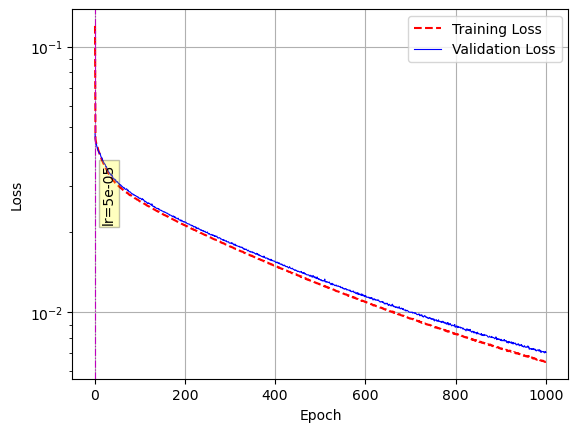

<Figure size 640x480 with 0 Axes>

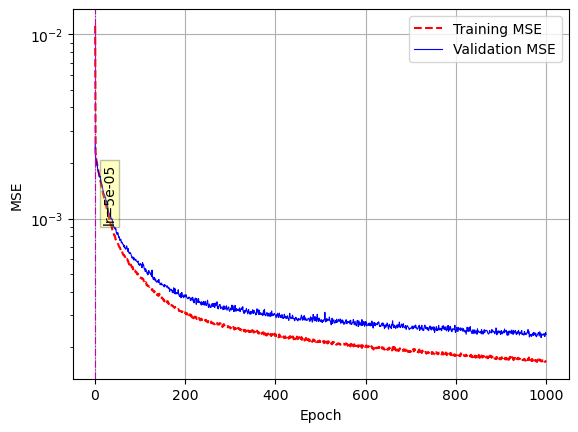

<Figure size 640x480 with 0 Axes>

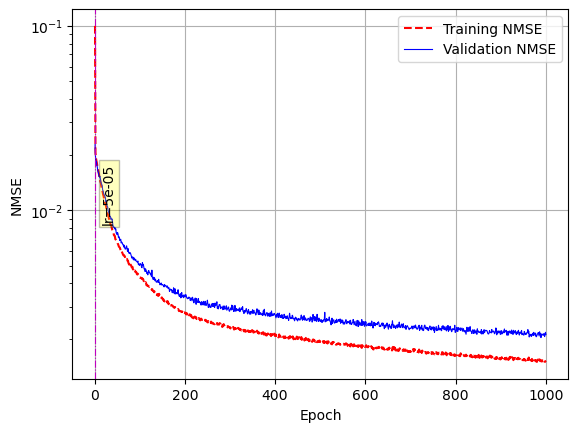

<Figure size 640x480 with 0 Axes>

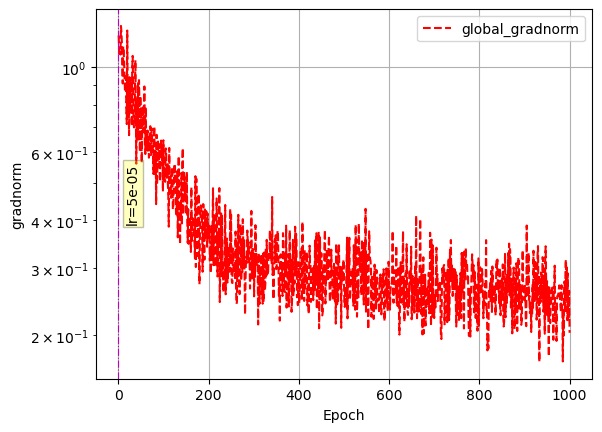



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.25


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0701 - mse: 0.0082 - NMSE: 0.0735 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.2500 - tot_time: 0h 0m 16.9s

Epoch 1: val_NMSE improved from inf to 0.03898, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/

Epoch 11/1000
71/71 [==============================] - ETA: 0s - loss: 0.0093 - mse: 5.3436e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.8771e-04 - global_gradnorm: 0.7310 - tot_time: 0h 1m 9.1s

Epoch 11: val_NMSE improved from 0.00521 to 0.00518, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 69ms/step - loss: 0.0093 - mse: 5.3436e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.8825e-04 - global_gradnorm: 0.7319 - val_loss: 0.0096 - val_mse: 5.7581e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0092 - mse: 5.2685e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8426e-04 - global_gradnorm: 0.7317 - tot_time: 0h 1m 14.3s

Epoch 12:

71/71 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.0177e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7249e-04 - global_gradnorm: 0.7136 - tot_time: 0h 2m 8.1s

Epoch 22: val_NMSE did not improve from 0.00491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0090 - mse: 5.0177e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7212e-04 - global_gradnorm: 0.7110 - val_loss: 0.0094 - val_mse: 5.5104e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/1000
71/71 [==============================] - ETA: 0s - loss: 0.0090 - mse: 4.9703e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7103e-04 - global_gradnorm: 0.6943 - tot_time: 0h 2m 14.0s

Epoch 23: val_NMSE did not improve from 0.00491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/che

Epoch 34/1000
71/71 [==============================] - ETA: 0s - loss: 0.0088 - mse: 4.7906e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6252e-04 - global_gradnorm: 0.6903 - tot_time: 0h 3m 15.9s

Epoch 34: val_NMSE did not improve from 0.00473
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 82ms/step - loss: 0.0088 - mse: 4.7906e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6236e-04 - global_gradnorm: 0.6900 - val_loss: 0.0093 - val_mse: 5.3814e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 35/1000
71/71 [==============================] - ETA: 0s - loss: 0.0088 - mse: 4.7945e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6261e-04 - global_gradnorm: 0.6855 - tot_time: 0h 3m 21.9s

Epoch 35: val_NMSE did not improve from 0.00473
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0088 - mse: 4.6949e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5880e-04 - global_gradnorm: 0.6978 - tot_time: 0h 4m 26.9s

Epoch 46: val_NMSE did not improve from 0.00473
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 88ms/step - loss: 0.0088 - mse: 4.6949e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5870e-04 - global_gradnorm: 0.6971 - val_loss: 0.0093 - val_mse: 5.3547e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0087 - mse: 4.6763e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5760e-04 - global_gradnorm: 0.6732 - tot_time: 0h 4m 32.5s

Epoch 47: val_NMSE did not improve from 0.00473
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/ch

Epoch 58/1000
71/71 [==============================] - ETA: 0s - loss: 0.0087 - mse: 4.6162e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5561e-04 - global_gradnorm: 0.6905 - tot_time: 0h 5m 36.3s

Epoch 58: val_NMSE did not improve from 0.00471
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 83ms/step - loss: 0.0087 - mse: 4.6162e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5536e-04 - global_gradnorm: 0.6900 - val_loss: 0.0092 - val_mse: 5.3276e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 59/1000
71/71 [==============================] - ETA: 0s - loss: 0.0087 - mse: 4.6148e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5530e-04 - global_gradnorm: 0.6918 - tot_time: 0h 5m 42.2s

Epoch 59: val_NMSE improved from 0.00471 to 0.00468, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 70/1000
71/71 [==============================] - ETA: 0s - loss: 0.0086 - mse: 4.5533e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5251e-04 - global_gradnorm: 0.6852 - tot_time: 0h 6m 45.8s

Epoch 70: val_NMSE improved from 0.00465 to 0.00463, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 83ms/step - loss: 0.0086 - mse: 4.5533e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5269e-04 - global_gradnorm: 0.6836 - val_loss: 0.0091 - val_mse: 5.1429e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 71/1000
71/71 [==============================] - ETA: 0s - loss: 0.0086 - mse: 4.5084e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5061e-04 - global_gradnorm: 0.6385 - tot_time: 0h 6m 51.7s

Epoch 71

Epoch 82/1000
71/71 [==============================] - ETA: 0s - loss: 0.0085 - mse: 4.4488e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4737e-04 - global_gradnorm: 0.6394 - tot_time: 0h 7m 55.9s

Epoch 82: val_NMSE did not improve from 0.00461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 87ms/step - loss: 0.0085 - mse: 4.4488e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4763e-04 - global_gradnorm: 0.6440 - val_loss: 0.0091 - val_mse: 5.1545e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 83/1000
71/71 [==============================] - ETA: 0s - loss: 0.0086 - mse: 4.4585e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4808e-04 - global_gradnorm: 0.6487 - tot_time: 0h 8m 1.8s

Epoch 83: val_NMSE did not improve from 0.00461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 94/1000
71/71 [==============================] - ETA: 0s - loss: 0.0085 - mse: 4.3969e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4497e-04 - global_gradnorm: 0.6362 - tot_time: 0h 9m 4.7s

Epoch 94: val_NMSE did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0085 - mse: 4.3969e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4492e-04 - global_gradnorm: 0.6368 - val_loss: 0.0091 - val_mse: 5.2192e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 95/1000
71/71 [==============================] - ETA: 0s - loss: 0.0085 - mse: 4.3917e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4491e-04 - global_gradnorm: 0.6360 - tot_time: 0h 9m 10.2s

Epoch 95: val_NMSE did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

71/71 [==============================] - ETA: 0s - loss: 0.0085 - mse: 4.3568e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4298e-04 - global_gradnorm: 0.6619 - tot_time: 0h 10m 14.7s

Epoch 106: val_NMSE improved from 0.00456 to 0.00455, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 90ms/step - loss: 0.0085 - mse: 4.3568e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4267e-04 - global_gradnorm: 0.6606 - val_loss: 0.0090 - val_mse: 5.0577e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 107/1000
71/71 [==============================] - ETA: 0s - loss: 0.0085 - mse: 4.3601e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4340e-04 - global_gradnorm: 0.6533 - tot_time: 0h 10m 20.3s

Epoch 107: val_NMS

Epoch 118/1000
71/71 [==============================] - ETA: 0s - loss: 0.0084 - mse: 4.3339e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4216e-04 - global_gradnorm: 0.6596 - tot_time: 0h 11m 24.1s

Epoch 118: val_NMSE did not improve from 0.00452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0084 - mse: 4.3339e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4229e-04 - global_gradnorm: 0.6607 - val_loss: 0.0091 - val_mse: 5.1881e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 119/1000
71/71 [==============================] - ETA: 0s - loss: 0.0084 - mse: 4.3138e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4124e-04 - global_gradnorm: 0.6530 - tot_time: 0h 11m 29.9s

Epoch 119: val_NMSE did not improve from 0.00452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0084 - mse: 4.2505e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3862e-04 - global_gradnorm: 0.6152 - tot_time: 0h 12m 33.7s

Epoch 130: val_NMSE did not improve from 0.00452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 85ms/step - loss: 0.0084 - mse: 4.2505e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3838e-04 - global_gradnorm: 0.6129 - val_loss: 0.0090 - val_mse: 5.0326e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 131/1000
71/71 [==============================] - ETA: 0s - loss: 0.0084 - mse: 4.2535e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3849e-04 - global_gradnorm: 0.6233 - tot_time: 0h 12m 39.9s

Epoch 131: val_NMSE did not improve from 0.00452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 142/1000
71/71 [==============================] - ETA: 0s - loss: 0.0084 - mse: 4.2335e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3759e-04 - global_gradnorm: 0.6373 - tot_time: 0h 13m 43.6s

Epoch 142: val_NMSE did not improve from 0.00449
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 75ms/step - loss: 0.0084 - mse: 4.2335e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3749e-04 - global_gradnorm: 0.6386 - val_loss: 0.0090 - val_mse: 5.0769e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 143/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.2025e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3643e-04 - global_gradnorm: 0.6347 - tot_time: 0h 13m 49.0s

Epoch 143: val_NMSE did not improve from 0.00449
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 154/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.1821e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3497e-04 - global_gradnorm: 0.6313 - tot_time: 0h 14m 50.6s

Epoch 154: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0083 - mse: 4.1821e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3515e-04 - global_gradnorm: 0.6318 - val_loss: 0.0090 - val_mse: 5.0149e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 155/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.2222e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3679e-04 - global_gradnorm: 0.6680 - tot_time: 0h 14m 56.3s

Epoch 155: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.1769e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3458e-04 - global_gradnorm: 0.6367 - tot_time: 0h 15m 57.8s

Epoch 166: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0083 - mse: 4.1769e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3505e-04 - global_gradnorm: 0.6376 - val_loss: 0.0090 - val_mse: 5.0850e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 167/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.1771e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3474e-04 - global_gradnorm: 0.6491 - tot_time: 0h 16m 3.4s

Epoch 167: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 178/1000
71/71 [==============================] - ETA: 0s - loss: 0.0083 - mse: 4.1243e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3233e-04 - global_gradnorm: 0.6378 - tot_time: 0h 17m 5.7s

Epoch 178: val_NMSE did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0083 - mse: 4.1243e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3235e-04 - global_gradnorm: 0.6397 - val_loss: 0.0090 - val_mse: 5.0614e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 179/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.1168e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3195e-04 - global_gradnorm: 0.6178 - tot_time: 0h 17m 11.4s

Epoch 179: val_NMSE did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 190/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0918e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3093e-04 - global_gradnorm: 0.6277 - tot_time: 0h 18m 12.6s

Epoch 190: val_NMSE did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 82ms/step - loss: 0.0082 - mse: 4.0918e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3078e-04 - global_gradnorm: 0.6288 - val_loss: 0.0089 - val_mse: 4.9465e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 191/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0903e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3052e-04 - global_gradnorm: 0.6372 - tot_time: 0h 18m 18.1s

Epoch 191: val_NMSE did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 202/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0550e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2901e-04 - global_gradnorm: 0.6037 - tot_time: 0h 19m 19.4s

Epoch 202: val_NMSE did not improve from 0.00440
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0082 - mse: 4.0550e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2898e-04 - global_gradnorm: 0.6048 - val_loss: 0.0089 - val_mse: 4.9528e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 203/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0602e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.2942e-04 - global_gradnorm: 0.6274 - tot_time: 0h 19m 24.8s

Epoch 203: val_NMSE did not improve from 0.00440
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 214/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0638e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.2964e-04 - global_gradnorm: 0.6365 - tot_time: 0h 20m 25.2s

Epoch 214: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0082 - mse: 4.0638e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.2988e-04 - global_gradnorm: 0.6361 - val_loss: 0.0089 - val_mse: 4.9344e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 215/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 4.0443e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2873e-04 - global_gradnorm: 0.6307 - tot_time: 0h 20m 30.5s

Epoch 215: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 4.0174e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2742e-04 - global_gradnorm: 0.6189 - tot_time: 0h 21m 32.3s

Epoch 226: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0081 - mse: 4.0174e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2767e-04 - global_gradnorm: 0.6194 - val_loss: 0.0088 - val_mse: 4.8946e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 227/1000
71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 4.0147e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2704e-04 - global_gradnorm: 0.5991 - tot_time: 0h 21m 37.6s

Epoch 227: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9796e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2558e-04 - global_gradnorm: 0.6055 - tot_time: 0h 22m 38.7s

Epoch 238: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 75ms/step - loss: 0.0081 - mse: 3.9796e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2540e-04 - global_gradnorm: 0.6044 - val_loss: 0.0088 - val_mse: 4.8482e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 239/1000
71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9948e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2629e-04 - global_gradnorm: 0.6371 - tot_time: 0h 22m 44.5s

Epoch 239: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9583e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2396e-04 - global_gradnorm: 0.6335 - tot_time: 0h 23m 45.0s

Epoch 250: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0081 - mse: 3.9583e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2365e-04 - global_gradnorm: 0.6329 - val_loss: 0.0088 - val_mse: 4.8281e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 251/1000
71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9579e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2426e-04 - global_gradnorm: 0.6122 - tot_time: 0h 23m 50.4s

Epoch 251: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9512e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2403e-04 - global_gradnorm: 0.6163 - tot_time: 0h 24m 51.4s

Epoch 262: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0081 - mse: 3.9512e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2399e-04 - global_gradnorm: 0.6159 - val_loss: 0.0088 - val_mse: 4.8943e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 263/1000
71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9441e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2345e-04 - global_gradnorm: 0.6188 - tot_time: 0h 24m 57.2s

Epoch 263: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.9194e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2191e-04 - global_gradnorm: 0.6233 - tot_time: 0h 25m 57.5s

Epoch 274: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0080 - mse: 3.9194e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2185e-04 - global_gradnorm: 0.6227 - val_loss: 0.0088 - val_mse: 4.8361e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 275/1000
71/71 [==============================] - ETA: 0s - loss: 0.0081 - mse: 3.9236e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2218e-04 - global_gradnorm: 0.6155 - tot_time: 0h 26m 3.1s

Epoch 275: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.9178e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2212e-04 - global_gradnorm: 0.6237 - tot_time: 0h 27m 3.9s

Epoch 286: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0080 - mse: 3.9178e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2220e-04 - global_gradnorm: 0.6239 - val_loss: 0.0087 - val_mse: 4.8169e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 287/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.9039e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2126e-04 - global_gradnorm: 0.6248 - tot_time: 0h 27m 9.5s

Epoch 287: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

Epoch 298/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8674e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2001e-04 - global_gradnorm: 0.6013 - tot_time: 0h 28m 10.9s

Epoch 298: val_NMSE did not improve from 0.00429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0080 - mse: 3.8674e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1992e-04 - global_gradnorm: 0.6036 - val_loss: 0.0088 - val_mse: 4.8687e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 299/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8923e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2100e-04 - global_gradnorm: 0.6176 - tot_time: 0h 28m 16.5s

Epoch 299: val_NMSE did not improve from 0.00429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 310/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8344e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1790e-04 - global_gradnorm: 0.5970 - tot_time: 0h 29m 16.6s

Epoch 310: val_NMSE improved from 0.00428 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 74ms/step - loss: 0.0080 - mse: 3.8344e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1827e-04 - global_gradnorm: 0.5990 - val_loss: 0.0087 - val_mse: 4.7456e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 311/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8524e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1863e-04 - global_gradnorm: 0.6244 - tot_time: 0h 29m 22.2s

Epo

Epoch 322/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8430e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1854e-04 - global_gradnorm: 0.6238 - tot_time: 0h 30m 22.5s

Epoch 322: val_NMSE did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0080 - mse: 3.8430e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1838e-04 - global_gradnorm: 0.6228 - val_loss: 0.0087 - val_mse: 4.8379e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 323/1000
71/71 [==============================] - ETA: 0s - loss: 0.0080 - mse: 3.8512e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1866e-04 - global_gradnorm: 0.6101 - tot_time: 0h 30m 27.8s

Epoch 323: val_NMSE did not improve from 0.00427
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 334/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.8070e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1691e-04 - global_gradnorm: 0.5792 - tot_time: 0h 31m 28.2s

Epoch 334: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0079 - mse: 3.8070e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1688e-04 - global_gradnorm: 0.5787 - val_loss: 0.0087 - val_mse: 4.7827e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 335/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7861e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1529e-04 - global_gradnorm: 0.5918 - tot_time: 0h 31m 34.0s

Epoch 335: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7881e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1543e-04 - global_gradnorm: 0.6081 - tot_time: 0h 32m 34.1s

Epoch 346: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0079 - mse: 3.7881e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1560e-04 - global_gradnorm: 0.6069 - val_loss: 0.0087 - val_mse: 4.7512e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 347/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7861e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1559e-04 - global_gradnorm: 0.5926 - tot_time: 0h 32m 39.6s

Epoch 347: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 358/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7834e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1561e-04 - global_gradnorm: 0.6012 - tot_time: 0h 33m 39.9s

Epoch 358: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 73ms/step - loss: 0.0079 - mse: 3.7834e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1485e-04 - global_gradnorm: 0.5996 - val_loss: 0.0087 - val_mse: 4.7613e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 359/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7677e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1468e-04 - global_gradnorm: 0.5924 - tot_time: 0h 33m 45.1s

Epoch 359: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7476e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1391e-04 - global_gradnorm: 0.5871 - tot_time: 0h 34m 46.5s

Epoch 370: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 81ms/step - loss: 0.0079 - mse: 3.7476e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1327e-04 - global_gradnorm: 0.5858 - val_loss: 0.0087 - val_mse: 4.7836e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 371/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7403e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1323e-04 - global_gradnorm: 0.5816 - tot_time: 0h 34m 51.9s

Epoch 371: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 3.7360e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1300e-04 - global_gradnorm: 0.5823 - tot_time: 0h 35m 53.8s

Epoch 382: val_NMSE improved from 0.00421 to 0.00421, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 82ms/step - loss: 0.0079 - mse: 3.7360e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1273e-04 - global_gradnorm: 0.5834 - val_loss: 0.0086 - val_mse: 4.6781e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 383/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.7027e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1102e-04 - global_gradnorm: 0.5742 - tot_time: 0h 35m 59.4s

Epoch 383: val_NMS

Epoch 394/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.7198e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1231e-04 - global_gradnorm: 0.5978 - tot_time: 0h 37m 0.6s

Epoch 394: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0078 - mse: 3.7198e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1212e-04 - global_gradnorm: 0.5975 - val_loss: 0.0086 - val_mse: 4.6642e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 395/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.7133e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1165e-04 - global_gradnorm: 0.5970 - tot_time: 0h 37m 6.0s

Epoch 395: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 406/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6950e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1106e-04 - global_gradnorm: 0.5931 - tot_time: 0h 38m 6.9s

Epoch 406: val_NMSE did not improve from 0.00417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0078 - mse: 3.6950e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1053e-04 - global_gradnorm: 0.5915 - val_loss: 0.0087 - val_mse: 4.7667e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 407/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.7089e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1166e-04 - global_gradnorm: 0.6003 - tot_time: 0h 38m 12.3s

Epoch 407: val_NMSE did not improve from 0.00417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 418/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6706e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0956e-04 - global_gradnorm: 0.5747 - tot_time: 0h 39m 13.4s

Epoch 418: val_NMSE did not improve from 0.00417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0078 - mse: 3.6706e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0958e-04 - global_gradnorm: 0.5746 - val_loss: 0.0086 - val_mse: 4.6894e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 419/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6704e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0962e-04 - global_gradnorm: 0.5675 - tot_time: 0h 39m 18.8s

Epoch 419: val_NMSE did not improve from 0.00417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 430/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6695e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0958e-04 - global_gradnorm: 0.5884 - tot_time: 0h 40m 19.6s

Epoch 430: val_NMSE did not improve from 0.00413
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0078 - mse: 3.6695e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0919e-04 - global_gradnorm: 0.5876 - val_loss: 0.0086 - val_mse: 4.6493e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 431/1000
71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6489e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0862e-04 - global_gradnorm: 0.5731 - tot_time: 0h 40m 25.1s

Epoch 431: val_NMSE did not improve from 0.00413
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0078 - mse: 3.6652e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0932e-04 - global_gradnorm: 0.5820 - tot_time: 0h 41m 27.0s

Epoch 442: val_NMSE improved from 0.00413 to 0.00412, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0078 - mse: 3.6652e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0984e-04 - global_gradnorm: 0.5805 - val_loss: 0.0085 - val_mse: 4.5825e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 443/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6311e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0734e-04 - global_gradnorm: 0.5745 - tot_time: 0h 41m 32.5s

Epoch 443: val_NMS

Epoch 454/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6226e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0710e-04 - global_gradnorm: 0.5842 - tot_time: 0h 42m 33.4s

Epoch 454: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 77ms/step - loss: 0.0077 - mse: 3.6226e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0731e-04 - global_gradnorm: 0.5829 - val_loss: 0.0085 - val_mse: 4.6003e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 455/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6249e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0714e-04 - global_gradnorm: 0.5713 - tot_time: 0h 42m 38.9s

Epoch 455: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6236e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0710e-04 - global_gradnorm: 0.5741 - tot_time: 0h 43m 39.6s

Epoch 466: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0077 - mse: 3.6236e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0694e-04 - global_gradnorm: 0.5748 - val_loss: 0.0085 - val_mse: 4.6563e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 467/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6231e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0700e-04 - global_gradnorm: 0.5840 - tot_time: 0h 43m 45.3s

Epoch 467: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5903e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0519e-04 - global_gradnorm: 0.5616 - tot_time: 0h 44m 46.5s

Epoch 478: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0077 - mse: 3.5903e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0543e-04 - global_gradnorm: 0.5601 - val_loss: 0.0086 - val_mse: 4.6795e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 479/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5996e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0578e-04 - global_gradnorm: 0.5851 - tot_time: 0h 44m 52.0s

Epoch 479: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.6005e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0586e-04 - global_gradnorm: 0.5867 - tot_time: 0h 45m 53.4s

Epoch 490: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0077 - mse: 3.6005e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0580e-04 - global_gradnorm: 0.5851 - val_loss: 0.0085 - val_mse: 4.6141e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 491/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5995e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0574e-04 - global_gradnorm: 0.5854 - tot_time: 0h 45m 59.0s

Epoch 491: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 502/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5417e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0295e-04 - global_gradnorm: 0.5484 - tot_time: 0h 47m 0.9s

Epoch 502: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0076 - mse: 3.5417e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0308e-04 - global_gradnorm: 0.5476 - val_loss: 0.0085 - val_mse: 4.5957e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 503/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5682e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0416e-04 - global_gradnorm: 0.5691 - tot_time: 0h 47m 6.6s

Epoch 503: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 514/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5661e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0408e-04 - global_gradnorm: 0.5973 - tot_time: 0h 48m 7.3s

Epoch 514: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 73ms/step - loss: 0.0077 - mse: 3.5661e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0425e-04 - global_gradnorm: 0.5980 - val_loss: 0.0085 - val_mse: 4.5919e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 515/1000
71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 3.5676e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0407e-04 - global_gradnorm: 0.5782 - tot_time: 0h 48m 13.0s

Epoch 515: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5429e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0261e-04 - global_gradnorm: 0.5748 - tot_time: 0h 49m 13.6s

Epoch 526: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0076 - mse: 3.5429e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0266e-04 - global_gradnorm: 0.5770 - val_loss: 0.0085 - val_mse: 4.6048e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 527/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5567e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0342e-04 - global_gradnorm: 0.5949 - tot_time: 0h 49m 19.1s

Epoch 527: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5350e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0252e-04 - global_gradnorm: 0.5840 - tot_time: 0h 50m 20.1s

Epoch 538: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 81ms/step - loss: 0.0076 - mse: 3.5350e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0216e-04 - global_gradnorm: 0.5842 - val_loss: 0.0085 - val_mse: 4.6289e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 539/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5195e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0169e-04 - global_gradnorm: 0.5502 - tot_time: 0h 50m 25.5s

Epoch 539: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5196e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0193e-04 - global_gradnorm: 0.5658 - tot_time: 0h 51m 26.2s

Epoch 550: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0076 - mse: 3.5196e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0194e-04 - global_gradnorm: 0.5658 - val_loss: 0.0085 - val_mse: 4.6161e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 551/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5187e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0168e-04 - global_gradnorm: 0.5694 - tot_time: 0h 51m 32.0s

Epoch 551: val_NMSE did not improve from 0.00408
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 562/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.4770e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9925e-04 - global_gradnorm: 0.5449 - tot_time: 0h 52m 34.3s

Epoch 562: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0076 - mse: 3.4770e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9916e-04 - global_gradnorm: 0.5434 - val_loss: 0.0084 - val_mse: 4.5570e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 563/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.4809e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9937e-04 - global_gradnorm: 0.5489 - tot_time: 0h 52m 40.0s

Epoch 563: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.4931e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0023e-04 - global_gradnorm: 0.5673 - tot_time: 0h 53m 42.5s

Epoch 574: val_NMSE improved from 0.00406 to 0.00406, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 82ms/step - loss: 0.0076 - mse: 3.4931e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0019e-04 - global_gradnorm: 0.5671 - val_loss: 0.0084 - val_mse: 4.5075e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 575/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.5150e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0101e-04 - global_gradnorm: 0.5773 - tot_time: 0h 53m 48.2s

Epoch 575: val_NMS

Epoch 586/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.4832e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9969e-04 - global_gradnorm: 0.5535 - tot_time: 0h 54m 50.0s

Epoch 586: val_NMSE did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0076 - mse: 3.4832e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9916e-04 - global_gradnorm: 0.5520 - val_loss: 0.0084 - val_mse: 4.5346e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 587/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4431e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9749e-04 - global_gradnorm: 0.5506 - tot_time: 0h 54m 55.4s

Epoch 587: val_NMSE did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 598/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4502e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9793e-04 - global_gradnorm: 0.5577 - tot_time: 0h 55m 55.5s

Epoch 598: val_NMSE did not improve from 0.00404
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 74ms/step - loss: 0.0075 - mse: 3.4502e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9776e-04 - global_gradnorm: 0.5564 - val_loss: 0.0084 - val_mse: 4.5339e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 599/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 3.4794e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9958e-04 - global_gradnorm: 0.5756 - tot_time: 0h 56m 1.2s

Epoch 599: val_NMSE did not improve from 0.00404
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 610/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4459e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9779e-04 - global_gradnorm: 0.5650 - tot_time: 0h 57m 2.2s

Epoch 610: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0075 - mse: 3.4459e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9785e-04 - global_gradnorm: 0.5660 - val_loss: 0.0084 - val_mse: 4.5243e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 611/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4348e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9722e-04 - global_gradnorm: 0.5571 - tot_time: 0h 57m 7.7s

Epoch 611: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 622/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4377e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9698e-04 - global_gradnorm: 0.5532 - tot_time: 0h 58m 8.5s

Epoch 622: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 73ms/step - loss: 0.0075 - mse: 3.4377e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9716e-04 - global_gradnorm: 0.5530 - val_loss: 0.0084 - val_mse: 4.5686e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 623/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4264e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9664e-04 - global_gradnorm: 0.5454 - tot_time: 0h 58m 13.5s

Epoch 623: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4156e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9606e-04 - global_gradnorm: 0.5534 - tot_time: 0h 59m 15.1s

Epoch 634: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0075 - mse: 3.4156e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9572e-04 - global_gradnorm: 0.5548 - val_loss: 0.0084 - val_mse: 4.5503e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 635/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4407e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9745e-04 - global_gradnorm: 0.5564 - tot_time: 0h 59m 20.5s

Epoch 635: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 646/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.3973e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9487e-04 - global_gradnorm: 0.5392 - tot_time: 1h 0m 25.0s

Epoch 646: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0075 - mse: 3.3973e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9463e-04 - global_gradnorm: 0.5376 - val_loss: 0.0083 - val_mse: 4.5081e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 647/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.3899e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9501e-04 - global_gradnorm: 0.5359 - tot_time: 1h 0m 30.7s

Epoch 647: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.3916e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9511e-04 - global_gradnorm: 0.5474 - tot_time: 1h 1m 31.9s

Epoch 658: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0075 - mse: 3.3916e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9482e-04 - global_gradnorm: 0.5493 - val_loss: 0.0083 - val_mse: 4.4516e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 659/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.3982e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9532e-04 - global_gradnorm: 0.5602 - tot_time: 1h 1m 37.2s

Epoch 659: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.3950e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9520e-04 - global_gradnorm: 0.5617 - tot_time: 1h 2m 38.2s

Epoch 670: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0075 - mse: 3.3950e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9491e-04 - global_gradnorm: 0.5611 - val_loss: 0.0083 - val_mse: 4.4969e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 671/1000
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4052e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9569e-04 - global_gradnorm: 0.5622 - tot_time: 1h 2m 43.7s

Epoch 671: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 3.4041e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9535e-04 - global_gradnorm: 0.5772 - tot_time: 1h 3m 45.3s

Epoch 682: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0075 - mse: 3.4041e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9526e-04 - global_gradnorm: 0.5776 - val_loss: 0.0083 - val_mse: 4.4834e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 683/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3905e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9451e-04 - global_gradnorm: 0.5614 - tot_time: 1h 3m 51.1s

Epoch 683: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3563e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9275e-04 - global_gradnorm: 0.5490 - tot_time: 1h 4m 52.2s

Epoch 694: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0074 - mse: 3.3563e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9292e-04 - global_gradnorm: 0.5479 - val_loss: 0.0083 - val_mse: 4.4934e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 695/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3585e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9339e-04 - global_gradnorm: 0.5330 - tot_time: 1h 4m 57.9s

Epoch 695: val_NMSE improved from 0.00399 to 0.00398, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkp

Epoch 706/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3538e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9266e-04 - global_gradnorm: 0.5513 - tot_time: 1h 5m 59.4s

Epoch 706: val_NMSE did not improve from 0.00398
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0074 - mse: 3.3538e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9326e-04 - global_gradnorm: 0.5522 - val_loss: 0.0083 - val_mse: 4.4518e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 707/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3646e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9358e-04 - global_gradnorm: 0.5584 - tot_time: 1h 6m 4.8s

Epoch 707: val_NMSE did not improve from 0.00398
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 718/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3534e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9275e-04 - global_gradnorm: 0.5464 - tot_time: 1h 7m 6.3s

Epoch 718: val_NMSE did not improve from 0.00397
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0074 - mse: 3.3534e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9269e-04 - global_gradnorm: 0.5454 - val_loss: 0.0082 - val_mse: 4.4401e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 719/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3394e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9192e-04 - global_gradnorm: 0.5508 - tot_time: 1h 7m 12.1s

Epoch 719: val_NMSE improved from 0.00397 to 0.00395, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_

Epoch 730/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3232e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9126e-04 - global_gradnorm: 0.5427 - tot_time: 1h 8m 13.5s

Epoch 730: val_NMSE did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 83ms/step - loss: 0.0074 - mse: 3.3232e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9118e-04 - global_gradnorm: 0.5431 - val_loss: 0.0082 - val_mse: 4.4046e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 731/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3363e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9188e-04 - global_gradnorm: 0.5632 - tot_time: 1h 8m 18.9s

Epoch 731: val_NMSE did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 742/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3298e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9132e-04 - global_gradnorm: 0.5529 - tot_time: 1h 9m 19.1s

Epoch 742: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0074 - mse: 3.3298e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9108e-04 - global_gradnorm: 0.5551 - val_loss: 0.0082 - val_mse: 4.4267e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 743/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 3.3327e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9152e-04 - global_gradnorm: 0.5599 - tot_time: 1h 9m 24.8s

Epoch 743: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.3163e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9073e-04 - global_gradnorm: 0.5451 - tot_time: 1h 10m 25.8s

Epoch 754: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0073 - mse: 3.3163e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9097e-04 - global_gradnorm: 0.5433 - val_loss: 0.0082 - val_mse: 4.4241e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 755/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2977e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8964e-04 - global_gradnorm: 0.5324 - tot_time: 1h 10m 31.7s

Epoch 755: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2987e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8970e-04 - global_gradnorm: 0.5336 - tot_time: 1h 11m 33.2s

Epoch 766: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0073 - mse: 3.2987e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8993e-04 - global_gradnorm: 0.5347 - val_loss: 0.0082 - val_mse: 4.3866e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 767/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.3092e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8993e-04 - global_gradnorm: 0.5665 - tot_time: 1h 11m 38.8s

Epoch 767: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2927e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8932e-04 - global_gradnorm: 0.5407 - tot_time: 1h 12m 38.6s

Epoch 778: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 74ms/step - loss: 0.0073 - mse: 3.2927e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8903e-04 - global_gradnorm: 0.5410 - val_loss: 0.0082 - val_mse: 4.4375e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 779/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2959e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8987e-04 - global_gradnorm: 0.5506 - tot_time: 1h 12m 44.0s

Epoch 779: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 790/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2751e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8814e-04 - global_gradnorm: 0.5392 - tot_time: 1h 13m 45.9s

Epoch 790: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 79ms/step - loss: 0.0073 - mse: 3.2751e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8808e-04 - global_gradnorm: 0.5388 - val_loss: 0.0082 - val_mse: 4.3968e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 791/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2717e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8838e-04 - global_gradnorm: 0.5313 - tot_time: 1h 13m 51.8s

Epoch 791: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2566e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8715e-04 - global_gradnorm: 0.5178 - tot_time: 1h 14m 53.4s

Epoch 802: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 82ms/step - loss: 0.0073 - mse: 3.2566e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8733e-04 - global_gradnorm: 0.5183 - val_loss: 0.0082 - val_mse: 4.3863e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 803/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2790e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8883e-04 - global_gradnorm: 0.5473 - tot_time: 1h 14m 58.9s

Epoch 803: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2666e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8779e-04 - global_gradnorm: 0.5486 - tot_time: 1h 15m 59.9s

Epoch 814: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0073 - mse: 3.2666e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8748e-04 - global_gradnorm: 0.5480 - val_loss: 0.0082 - val_mse: 4.4050e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 815/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2591e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8784e-04 - global_gradnorm: 0.5350 - tot_time: 1h 16m 5.5s

Epoch 815: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2514e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8715e-04 - global_gradnorm: 0.5371 - tot_time: 1h 17m 5.9s

Epoch 826: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 73ms/step - loss: 0.0073 - mse: 3.2514e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8724e-04 - global_gradnorm: 0.5369 - val_loss: 0.0081 - val_mse: 4.3615e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 827/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2633e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8765e-04 - global_gradnorm: 0.5450 - tot_time: 1h 17m 10.9s

Epoch 827: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2396e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8644e-04 - global_gradnorm: 0.5470 - tot_time: 1h 18m 11.7s

Epoch 838: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 74ms/step - loss: 0.0072 - mse: 3.2396e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8613e-04 - global_gradnorm: 0.5467 - val_loss: 0.0082 - val_mse: 4.4159e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 839/1000
71/71 [==============================] - ETA: 0s - loss: 0.0073 - mse: 3.2514e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8718e-04 - global_gradnorm: 0.5642 - tot_time: 1h 18m 17.1s

Epoch 839: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2409e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8666e-04 - global_gradnorm: 0.5620 - tot_time: 1h 19m 17.9s

Epoch 850: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 81ms/step - loss: 0.0072 - mse: 3.2409e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8703e-04 - global_gradnorm: 0.5619 - val_loss: 0.0082 - val_mse: 4.3968e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 851/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2378e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8657e-04 - global_gradnorm: 0.5409 - tot_time: 1h 19m 23.5s

Epoch 851: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2200e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8514e-04 - global_gradnorm: 0.5439 - tot_time: 1h 20m 24.0s

Epoch 862: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0072 - mse: 3.2200e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8480e-04 - global_gradnorm: 0.5456 - val_loss: 0.0082 - val_mse: 4.4195e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 863/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2287e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8566e-04 - global_gradnorm: 0.5399 - tot_time: 1h 20m 29.7s

Epoch 863: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2277e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8582e-04 - global_gradnorm: 0.5461 - tot_time: 1h 21m 30.4s

Epoch 874: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0072 - mse: 3.2277e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8551e-04 - global_gradnorm: 0.5455 - val_loss: 0.0081 - val_mse: 4.3495e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 875/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2129e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8507e-04 - global_gradnorm: 0.5506 - tot_time: 1h 21m 36.2s

Epoch 875: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 886/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2237e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8561e-04 - global_gradnorm: 0.5601 - tot_time: 1h 22m 38.1s

Epoch 886: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 76ms/step - loss: 0.0072 - mse: 3.2237e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8563e-04 - global_gradnorm: 0.5594 - val_loss: 0.0081 - val_mse: 4.3118e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 887/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2176e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8482e-04 - global_gradnorm: 0.5497 - tot_time: 1h 22m 43.4s

Epoch 887: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1892e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8363e-04 - global_gradnorm: 0.5306 - tot_time: 1h 23m 45.8s

Epoch 898: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 81ms/step - loss: 0.0072 - mse: 3.1892e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8354e-04 - global_gradnorm: 0.5297 - val_loss: 0.0081 - val_mse: 4.3619e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 899/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1929e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8402e-04 - global_gradnorm: 0.5356 - tot_time: 1h 23m 51.2s

Epoch 899: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1959e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8405e-04 - global_gradnorm: 0.5514 - tot_time: 1h 24m 51.8s

Epoch 910: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0072 - mse: 3.1959e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8364e-04 - global_gradnorm: 0.5506 - val_loss: 0.0081 - val_mse: 4.3683e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 911/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.2050e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8416e-04 - global_gradnorm: 0.5494 - tot_time: 1h 24m 57.4s

Epoch 911: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 922/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1832e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8349e-04 - global_gradnorm: 0.5407 - tot_time: 1h 25m 58.8s

Epoch 922: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 77ms/step - loss: 0.0072 - mse: 3.1832e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8346e-04 - global_gradnorm: 0.5402 - val_loss: 0.0081 - val_mse: 4.3591e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 923/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1886e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8343e-04 - global_gradnorm: 0.5577 - tot_time: 1h 26m 4.1s

Epoch 923: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1575e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8157e-04 - global_gradnorm: 0.5121 - tot_time: 1h 27m 4.7s

Epoch 934: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 75ms/step - loss: 0.0071 - mse: 3.1575e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8113e-04 - global_gradnorm: 0.5126 - val_loss: 0.0080 - val_mse: 4.2924e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 935/1000
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 3.1824e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8325e-04 - global_gradnorm: 0.5436 - tot_time: 1h 27m 10.4s

Epoch 935: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1708e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8277e-04 - global_gradnorm: 0.5359 - tot_time: 1h 28m 11.7s

Epoch 946: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 81ms/step - loss: 0.0071 - mse: 3.1708e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8265e-04 - global_gradnorm: 0.5346 - val_loss: 0.0081 - val_mse: 4.3802e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 947/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1649e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8225e-04 - global_gradnorm: 0.5439 - tot_time: 1h 28m 17.3s

Epoch 947: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 958/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1284e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8023e-04 - global_gradnorm: 0.4991 - tot_time: 1h 29m 18.4s

Epoch 958: val_NMSE did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 73ms/step - loss: 0.0071 - mse: 3.1284e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8013e-04 - global_gradnorm: 0.4992 - val_loss: 0.0080 - val_mse: 4.3270e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 959/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1804e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8330e-04 - global_gradnorm: 0.5482 - tot_time: 1h 29m 23.7s

Epoch 959: val_NMSE did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 970/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1685e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8247e-04 - global_gradnorm: 0.5517 - tot_time: 1h 30m 25.3s

Epoch 970: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 77ms/step - loss: 0.0071 - mse: 3.1685e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8240e-04 - global_gradnorm: 0.5517 - val_loss: 0.0081 - val_mse: 4.3481e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 971/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1285e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8004e-04 - global_gradnorm: 0.5270 - tot_time: 1h 30m 30.2s

Epoch 971: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1456e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8123e-04 - global_gradnorm: 0.5375 - tot_time: 1h 31m 30.5s

Epoch 982: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 78ms/step - loss: 0.0071 - mse: 3.1456e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8167e-04 - global_gradnorm: 0.5395 - val_loss: 0.0081 - val_mse: 4.3797e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 983/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1335e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8025e-04 - global_gradnorm: 0.5199 - tot_time: 1h 31m 36.1s

Epoch 983: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1236e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7986e-04 - global_gradnorm: 0.5223 - tot_time: 1h 32m 36.9s

Epoch 994: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 80ms/step - loss: 0.0071 - mse: 3.1236e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.8019e-04 - global_gradnorm: 0.5240 - val_loss: 0.0080 - val_mse: 4.3183e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 995/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 3.1211e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7966e-04 - global_gradnorm: 0.5321 - tot_time: 1h 32m 42.3s

Epoch 995: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

<Figure size 640x480 with 0 Axes>

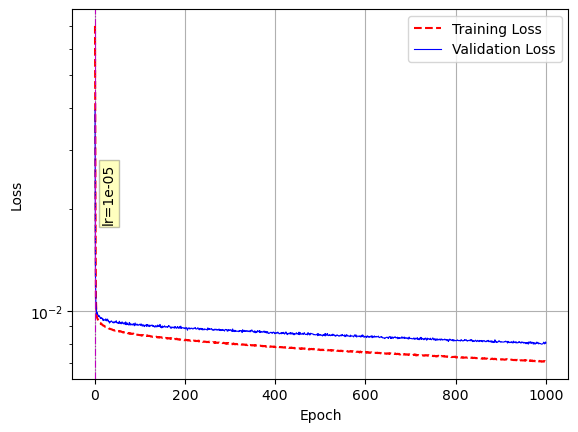

<Figure size 640x480 with 0 Axes>

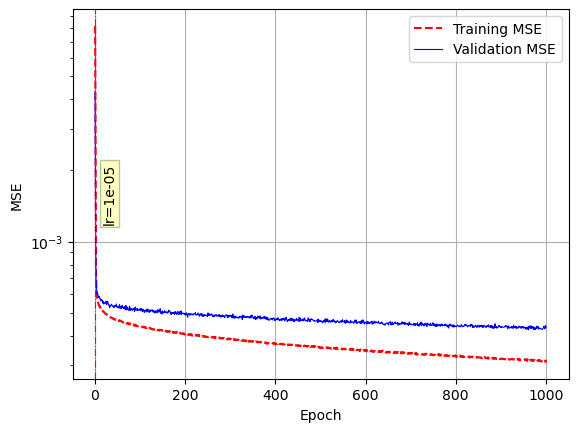

<Figure size 640x480 with 0 Axes>

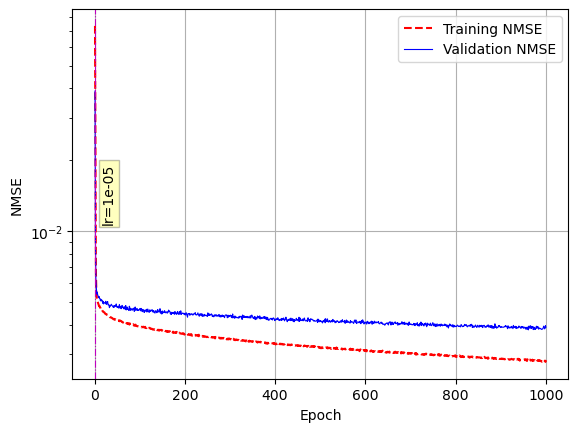

<Figure size 640x480 with 0 Axes>

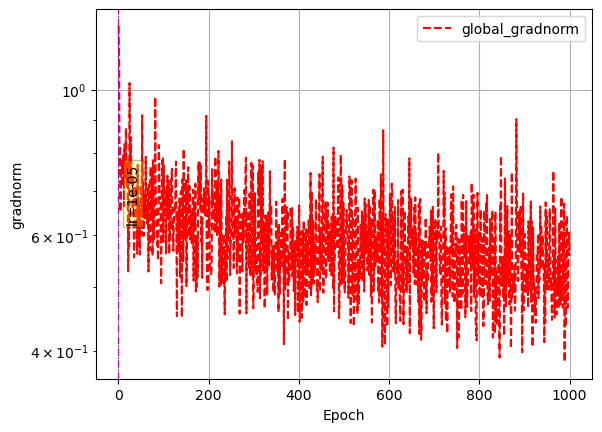



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.25


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
67/67 [==============================] - ETA: 0s - loss: 0.0951 - mse: 0.0121 - NMSE: 0.1090 - covmat_fro_loss: 0.0050 - global_gradnorm: 1.2500 - tot_time: 0h 0m 22.9s

Epoch 1: val_NMSE improved from inf to 0.09954, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/

Epoch 11/1000
67/67 [==============================] - ETA: 0s - loss: 0.0118 - mse: 9.8077e-04 - NMSE: 0.0088 - covmat_fro_loss: 9.0236e-04 - global_gradnorm: 1.2306 - tot_time: 0h 1m 21.7s

Epoch 11: val_NMSE improved from 0.00992 to 0.00906, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 91ms/step - loss: 0.0118 - mse: 9.8077e-04 - NMSE: 0.0088 - covmat_fro_loss: 9.0133e-04 - global_gradnorm: 1.2309 - val_loss: 0.0120 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
67/67 [==============================] - ETA: 0s - loss: 0.0113 - mse: 9.0537e-04 - NMSE: 0.0081 - covmat_fro_loss: 8.5690e-04 - global_gradnorm: 1.2221 - tot_time: 0h 1m 27.4s

Epoch 12: va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0102 - mse: 7.6349e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.7357e-04 - global_gradnorm: 1.1646 - val_loss: 0.0108 - val_mse: 8.4004e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 22/1000
67/67 [==============================] - ETA: 0s - loss: 0.0102 - mse: 7.6258e-04 - NMSE: 0.0069 - covmat_fro_loss: 7.7447e-04 - global_gradnorm: 1.1971 - tot_time: 0h 2m 27.5s

Epoch 22: val_NMSE improved from 0.00756 to 0.00754, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 90ms/step

67/67 [==============================] - ETA: 0s - loss: 0.0100 - mse: 7.3315e-04 - NMSE: 0.0066 - covmat_fro_loss: 7.5809e-04 - global_gradnorm: 1.1549 - tot_time: 0h 3m 27.7s

Epoch 32: val_NMSE improved from 0.00739 to 0.00734, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 96ms/step - loss: 0.0100 - mse: 7.3315e-04 - NMSE: 0.0066 - covmat_fro_loss: 7.5868e-04 - global_gradnorm: 1.1532 - val_loss: 0.0106 - val_mse: 8.1560e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 33/1000
67/67 [==============================] - ETA: 0s - loss: 0.0100 - mse: 7.3034e-04 - NMSE: 0.0066 - covmat_fro_loss: 7.5688e-04 - global_gradnorm: 1.1261 - tot_time: 0h 3m 33.5s

Epoch 33: val_NMSE did

Epoch 44/1000
67/67 [==============================] - ETA: 0s - loss: 0.0099 - mse: 7.1825e-04 - NMSE: 0.0065 - covmat_fro_loss: 7.5094e-04 - global_gradnorm: 1.1468 - tot_time: 0h 4m 38.4s

Epoch 44: val_NMSE did not improve from 0.00726
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0099 - mse: 7.1825e-04 - NMSE: 0.0065 - covmat_fro_loss: 7.5050e-04 - global_gradnorm: 1.1448 - val_loss: 0.0105 - val_mse: 8.1133e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/1000
67/67 [==============================] - ETA: 0s - loss: 0.0098 - mse: 7.1476e-04 - NMSE: 0.0064 - covmat_fro_loss: 7.4866e-04 - global_gradnorm: 1.1414 - tot_time: 0h 4m 44.4s

Epoch 45: val_NMSE improved from 0.00726 to 0.00722, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

67/67 [==============================] - ETA: 0s - loss: 0.0098 - mse: 7.0254e-04 - NMSE: 0.0063 - covmat_fro_loss: 7.4252e-04 - global_gradnorm: 1.1184 - tot_time: 0h 5m 43.5s

Epoch 55: val_NMSE improved from 0.00718 to 0.00717, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0098 - mse: 7.0254e-04 - NMSE: 0.0063 - covmat_fro_loss: 7.4271e-04 - global_gradnorm: 1.1172 - val_loss: 0.0104 - val_mse: 7.9713e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 56/1000
67/67 [==============================] - ETA: 0s - loss: 0.0098 - mse: 7.0380e-04 - NMSE: 0.0063 - covmat_fro_loss: 7.4293e-04 - global_gradnorm: 1.1517 - tot_time: 0h 5m 49.6s

Epoch 56: val_NMSE did

Epoch 67/1000
67/67 [==============================] - ETA: 0s - loss: 0.0097 - mse: 6.9402e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3806e-04 - global_gradnorm: 1.1065 - tot_time: 0h 6m 54.0s

Epoch 67: val_NMSE did not improve from 0.00712
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0097 - mse: 6.9402e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3804e-04 - global_gradnorm: 1.1044 - val_loss: 0.0104 - val_mse: 7.9205e-04 - val_NMSE: 0.0071 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 68/1000
67/67 [==============================] - ETA: 0s - loss: 0.0097 - mse: 6.9200e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3733e-04 - global_gradnorm: 1.1164 - tot_time: 0h 6m 59.6s

Epoch 68: val_NMSE improved from 0.00712 to 0.00710, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0096 - mse: 6.8496e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3315e-04 - global_gradnorm: 1.1060 - val_loss: 0.0103 - val_mse: 7.8287e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 79/1000
67/67 [==============================] - ETA: 0s - loss: 0.0096 - mse: 6.8537e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3398e-04 - global_gradnorm: 1.1141 - tot_time: 0h 8m 3.9s

Epoch 79: val_NMSE did not improve from 0.00705
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0096 - mse: 6.8537e-04 - NMSE: 0.0062 - covmat_fro_loss: 7.3393e-04 - global_gradnorm: 1.1133 - val_loss: 0.0104 - va

Epoch 90/1000
67/67 [==============================] - ETA: 0s - loss: 0.0096 - mse: 6.7963e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.3127e-04 - global_gradnorm: 1.1145 - tot_time: 0h 9m 8.3s

Epoch 90: val_NMSE did not improve from 0.00698
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0096 - mse: 6.7963e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.3088e-04 - global_gradnorm: 1.1143 - val_loss: 0.0103 - val_mse: 7.7866e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 91/1000
67/67 [==============================] - ETA: 0s - loss: 0.0096 - mse: 6.7970e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.3119e-04 - global_gradnorm: 1.0969 - tot_time: 0h 9m 14.4s

Epoch 91: val_NMSE did not improve from 0.00698
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.7239e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.2788e-04 - global_gradnorm: 1.1135 - tot_time: 0h 10m 19.2s

Epoch 102: val_NMSE did not improve from 0.00698
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0095 - mse: 6.7239e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.2745e-04 - global_gradnorm: 1.1097 - val_loss: 0.0103 - val_mse: 7.7659e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 103/1000
67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.7266e-04 - NMSE: 0.0061 - covmat_fro_loss: 7.2764e-04 - global_gradnorm: 1.0765 - tot_time: 0h 10m 24.8s

Epoch 103: val_NMSE improved from 0.00698 to 0.00698, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/chec

Epoch 114/1000
67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.6760e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2516e-04 - global_gradnorm: 1.0805 - tot_time: 0h 11m 29.6s

Epoch 114: val_NMSE did not improve from 0.00690
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 92ms/step - loss: 0.0095 - mse: 6.6760e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2581e-04 - global_gradnorm: 1.0814 - val_loss: 0.0103 - val_mse: 7.7081e-04 - val_NMSE: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 115/1000
67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.6495e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2403e-04 - global_gradnorm: 1.0628 - tot_time: 0h 11m 35.3s

Epoch 115: val_NMSE did not improve from 0.00690
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.6258e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2267e-04 - global_gradnorm: 1.1185 - tot_time: 0h 12m 38.7s

Epoch 126: val_NMSE did not improve from 0.00690
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0095 - mse: 6.6258e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2298e-04 - global_gradnorm: 1.1184 - val_loss: 0.0103 - val_mse: 7.7519e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 127/1000
67/67 [==============================] - ETA: 0s - loss: 0.0095 - mse: 6.6179e-04 - NMSE: 0.0060 - covmat_fro_loss: 7.2239e-04 - global_gradnorm: 1.0795 - tot_time: 0h 12m 44.3s

Epoch 127: val_NMSE did not improve from 0.00690
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 138/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.5619e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1949e-04 - global_gradnorm: 1.0873 - tot_time: 0h 13m 48.2s

Epoch 138: val_NMSE did not improve from 0.00687
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0094 - mse: 6.5619e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1942e-04 - global_gradnorm: 1.0844 - val_loss: 0.0102 - val_mse: 7.6991e-04 - val_NMSE: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 139/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.5655e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1966e-04 - global_gradnorm: 1.0738 - tot_time: 0h 13m 54.1s

Epoch 139: val_NMSE did not improve from 0.00687
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 150/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.5390e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1895e-04 - global_gradnorm: 1.0866 - tot_time: 0h 14m 59.1s

Epoch 150: val_NMSE did not improve from 0.00685
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0094 - mse: 6.5390e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1774e-04 - global_gradnorm: 1.0863 - val_loss: 0.0102 - val_mse: 7.6556e-04 - val_NMSE: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 151/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.5403e-04 - NMSE: 0.0059 - covmat_fro_loss: 7.1827e-04 - global_gradnorm: 1.0982 - tot_time: 0h 15m 5.3s

Epoch 151: val_NMSE did not improve from 0.00685
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 162/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.4808e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1560e-04 - global_gradnorm: 1.0761 - tot_time: 0h 16m 10.3s

Epoch 162: val_NMSE did not improve from 0.00681
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0094 - mse: 6.4808e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1592e-04 - global_gradnorm: 1.0767 - val_loss: 0.0102 - val_mse: 7.6017e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 163/1000
67/67 [==============================] - ETA: 0s - loss: 0.0094 - mse: 6.4880e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1549e-04 - global_gradnorm: 1.0487 - tot_time: 0h 16m 16.1s

Epoch 163: val_NMSE did not improve from 0.00681
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 174/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.4611e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1431e-04 - global_gradnorm: 1.0703 - tot_time: 0h 17m 20.6s

Epoch 174: val_NMSE did not improve from 0.00679
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0093 - mse: 6.4611e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1459e-04 - global_gradnorm: 1.0694 - val_loss: 0.0102 - val_mse: 7.6059e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 175/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.4589e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1471e-04 - global_gradnorm: 1.0716 - tot_time: 0h 17m 26.9s

Epoch 175: val_NMSE did not improve from 0.00679
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 186/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.4280e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1271e-04 - global_gradnorm: 1.0817 - tot_time: 0h 18m 31.4s

Epoch 186: val_NMSE did not improve from 0.00676
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0093 - mse: 6.4280e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1237e-04 - global_gradnorm: 1.0788 - val_loss: 0.0102 - val_mse: 7.5950e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 187/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.4011e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1151e-04 - global_gradnorm: 1.0643 - tot_time: 0h 18m 36.7s

Epoch 187: val_NMSE did not improve from 0.00676
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 198/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.4007e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1185e-04 - global_gradnorm: 1.0609 - tot_time: 0h 19m 41.3s

Epoch 198: val_NMSE did not improve from 0.00674
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 90ms/step - loss: 0.0093 - mse: 6.4007e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1135e-04 - global_gradnorm: 1.0598 - val_loss: 0.0101 - val_mse: 7.5453e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 199/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.3944e-04 - NMSE: 0.0058 - covmat_fro_loss: 7.1151e-04 - global_gradnorm: 1.0549 - tot_time: 0h 19m 47.2s

Epoch 199: val_NMSE did not improve from 0.00674
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 210/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.3658e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0981e-04 - global_gradnorm: 1.0601 - tot_time: 0h 20m 52.8s

Epoch 210: val_NMSE improved from 0.00674 to 0.00674, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0093 - mse: 6.3658e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0936e-04 - global_gradnorm: 1.0600 - val_loss: 0.0101 - val_mse: 7.4849e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 211/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.3310e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0813e-04 - global_gradnorm: 1.0555 - tot_time: 0h 20m 58.5s

Epo

Epoch 222/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.3261e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0775e-04 - global_gradnorm: 1.0537 - tot_time: 0h 22m 3.0s

Epoch 222: val_NMSE did not improve from 0.00674
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0092 - mse: 6.3261e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0848e-04 - global_gradnorm: 1.0556 - val_loss: 0.0101 - val_mse: 7.5255e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 223/1000
67/67 [==============================] - ETA: 0s - loss: 0.0093 - mse: 6.3434e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0926e-04 - global_gradnorm: 1.0553 - tot_time: 0h 22m 9.0s

Epoch 223: val_NMSE improved from 0.00674 to 0.00672, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR

Epoch 234/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.3187e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0787e-04 - global_gradnorm: 1.0618 - tot_time: 0h 23m 14.7s

Epoch 234: val_NMSE did not improve from 0.00670
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0092 - mse: 6.3187e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0723e-04 - global_gradnorm: 1.0604 - val_loss: 0.0101 - val_mse: 7.4748e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 235/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.3202e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0752e-04 - global_gradnorm: 1.0597 - tot_time: 0h 23m 20.4s

Epoch 235: val_NMSE did not improve from 0.00670
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2670e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0457e-04 - global_gradnorm: 1.0132 - tot_time: 0h 24m 24.2s

Epoch 246: val_NMSE did not improve from 0.00670
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0092 - mse: 6.2670e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0470e-04 - global_gradnorm: 1.0140 - val_loss: 0.0101 - val_mse: 7.4905e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 247/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2851e-04 - NMSE: 0.0057 - covmat_fro_loss: 7.0601e-04 - global_gradnorm: 1.0661 - tot_time: 0h 24m 29.9s

Epoch 247: val_NMSE did not improve from 0.00670
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 258/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2769e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0533e-04 - global_gradnorm: 1.0573 - tot_time: 0h 25m 33.9s

Epoch 258: val_NMSE did not improve from 0.00668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0092 - mse: 6.2769e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0513e-04 - global_gradnorm: 1.0599 - val_loss: 0.0101 - val_mse: 7.4936e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 259/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2501e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0404e-04 - global_gradnorm: 1.0374 - tot_time: 0h 25m 40.1s

Epoch 259: val_NMSE did not improve from 0.00668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2384e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0308e-04 - global_gradnorm: 1.0516 - tot_time: 0h 26m 44.3s

Epoch 270: val_NMSE did not improve from 0.00668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0092 - mse: 6.2384e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0285e-04 - global_gradnorm: 1.0531 - val_loss: 0.0101 - val_mse: 7.4953e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 271/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2422e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0383e-04 - global_gradnorm: 1.0547 - tot_time: 0h 26m 50.2s

Epoch 271: val_NMSE did not improve from 0.00668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 282/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2143e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0248e-04 - global_gradnorm: 1.0132 - tot_time: 0h 27m 55.7s

Epoch 282: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0092 - mse: 6.2143e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0202e-04 - global_gradnorm: 1.0103 - val_loss: 0.0101 - val_mse: 7.4520e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 283/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2157e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0234e-04 - global_gradnorm: 1.0364 - tot_time: 0h 28m 1.3s

Epoch 283: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 294/1000
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mse: 6.2073e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0188e-04 - global_gradnorm: 1.0521 - tot_time: 0h 29m 6.1s

Epoch 294: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0092 - mse: 6.2073e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0176e-04 - global_gradnorm: 1.0496 - val_loss: 0.0100 - val_mse: 7.3996e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 295/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1839e-04 - NMSE: 0.0056 - covmat_fro_loss: 7.0083e-04 - global_gradnorm: 1.0516 - tot_time: 0h 29m 12.0s

Epoch 295: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1638e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9942e-04 - global_gradnorm: 1.0087 - tot_time: 0h 30m 15.8s

Epoch 306: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0091 - mse: 6.1638e-04 - NMSE: 0.0055 - covmat_fro_loss: 7.0056e-04 - global_gradnorm: 1.0123 - val_loss: 0.0100 - val_mse: 7.4285e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 307/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1544e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9934e-04 - global_gradnorm: 1.0213 - tot_time: 0h 30m 21.6s

Epoch 307: val_NMSE did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 318/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1644e-04 - NMSE: 0.0055 - covmat_fro_loss: 7.0016e-04 - global_gradnorm: 1.0506 - tot_time: 0h 31m 25.7s

Epoch 318: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0091 - mse: 6.1644e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9888e-04 - global_gradnorm: 1.0463 - val_loss: 0.0101 - val_mse: 7.4520e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 319/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1438e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9905e-04 - global_gradnorm: 1.0286 - tot_time: 0h 31m 31.5s

Epoch 319: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1521e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9925e-04 - global_gradnorm: 1.0535 - tot_time: 0h 32m 34.9s

Epoch 330: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0091 - mse: 6.1521e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9897e-04 - global_gradnorm: 1.0559 - val_loss: 0.0100 - val_mse: 7.4426e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 331/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1374e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9858e-04 - global_gradnorm: 1.0359 - tot_time: 0h 32m 40.6s

Epoch 331: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1105e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9703e-04 - global_gradnorm: 1.0127 - tot_time: 0h 33m 45.3s

Epoch 342: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 90ms/step - loss: 0.0091 - mse: 6.1105e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9793e-04 - global_gradnorm: 1.0159 - val_loss: 0.0100 - val_mse: 7.4189e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 343/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1272e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9776e-04 - global_gradnorm: 1.0271 - tot_time: 0h 33m 51.1s

Epoch 343: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.0881e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9552e-04 - global_gradnorm: 1.0353 - tot_time: 0h 34m 55.8s

Epoch 354: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0091 - mse: 6.0881e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9510e-04 - global_gradnorm: 1.0335 - val_loss: 0.0100 - val_mse: 7.4014e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 355/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.1045e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9655e-04 - global_gradnorm: 1.0319 - tot_time: 0h 35m 1.8s

Epoch 355: val_NMSE did not improve from 0.00661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

Epoch 366/1000
67/67 [==============================] - ETA: 0s - loss: 0.0091 - mse: 6.0918e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9629e-04 - global_gradnorm: 1.0488 - tot_time: 0h 36m 5.3s

Epoch 366: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0091 - mse: 6.0918e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9661e-04 - global_gradnorm: 1.0481 - val_loss: 0.0100 - val_mse: 7.4105e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 367/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0725e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9472e-04 - global_gradnorm: 1.0228 - tot_time: 0h 36m 11.1s

Epoch 367: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0503e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9391e-04 - global_gradnorm: 1.0219 - tot_time: 0h 37m 14.9s

Epoch 378: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0090 - mse: 6.0503e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9381e-04 - global_gradnorm: 1.0215 - val_loss: 0.0100 - val_mse: 7.3566e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 379/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0544e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9377e-04 - global_gradnorm: 1.0579 - tot_time: 0h 37m 20.3s

Epoch 379: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0592e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9415e-04 - global_gradnorm: 1.0434 - tot_time: 0h 38m 24.4s

Epoch 390: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0090 - mse: 6.0592e-04 - NMSE: 0.0055 - covmat_fro_loss: 6.9395e-04 - global_gradnorm: 1.0453 - val_loss: 0.0100 - val_mse: 7.3508e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 391/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0413e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9323e-04 - global_gradnorm: 0.9942 - tot_time: 0h 38m 30.2s

Epoch 391: val_NMSE did not improve from 0.00659
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 402/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0382e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9345e-04 - global_gradnorm: 1.0134 - tot_time: 0h 39m 35.3s

Epoch 402: val_NMSE did not improve from 0.00658
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 90ms/step - loss: 0.0090 - mse: 6.0382e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9297e-04 - global_gradnorm: 1.0135 - val_loss: 0.0100 - val_mse: 7.3228e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 403/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0320e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9323e-04 - global_gradnorm: 1.0190 - tot_time: 0h 39m 41.2s

Epoch 403: val_NMSE did not improve from 0.00658
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 414/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0238e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9230e-04 - global_gradnorm: 1.0335 - tot_time: 0h 40m 45.8s

Epoch 414: val_NMSE did not improve from 0.00656
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0090 - mse: 6.0238e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9222e-04 - global_gradnorm: 1.0305 - val_loss: 0.0100 - val_mse: 7.4058e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 415/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0141e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9207e-04 - global_gradnorm: 1.0081 - tot_time: 0h 40m 51.3s

Epoch 415: val_NMSE did not improve from 0.00656
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 426/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0093e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9183e-04 - global_gradnorm: 1.0295 - tot_time: 0h 41m 56.7s

Epoch 426: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 92ms/step - loss: 0.0090 - mse: 6.0093e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9284e-04 - global_gradnorm: 1.0288 - val_loss: 0.0100 - val_mse: 7.3450e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 427/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 6.0043e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9142e-04 - global_gradnorm: 1.0217 - tot_time: 0h 42m 2.6s

Epoch 427: val_NMSE improved from 0.00654 to 0.00654, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 438/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9836e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9020e-04 - global_gradnorm: 1.0194 - tot_time: 0h 43m 6.4s

Epoch 438: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0090 - mse: 5.9836e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9039e-04 - global_gradnorm: 1.0206 - val_loss: 0.0100 - val_mse: 7.3601e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 439/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9876e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9048e-04 - global_gradnorm: 1.0056 - tot_time: 0h 43m 13.0s

Epoch 439: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9576e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8950e-04 - global_gradnorm: 0.9824 - tot_time: 0h 44m 17.4s

Epoch 450: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0090 - mse: 5.9576e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8927e-04 - global_gradnorm: 0.9789 - val_loss: 0.0100 - val_mse: 7.3296e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 451/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9857e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.9050e-04 - global_gradnorm: 1.0270 - tot_time: 0h 44m 23.4s

Epoch 451: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9584e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8928e-04 - global_gradnorm: 0.9981 - tot_time: 0h 45m 27.3s

Epoch 462: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0090 - mse: 5.9584e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8944e-04 - global_gradnorm: 0.9954 - val_loss: 0.0099 - val_mse: 7.3125e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 463/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9748e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8984e-04 - global_gradnorm: 1.0431 - tot_time: 0h 45m 32.9s

Epoch 463: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 474/1000
67/67 [==============================] - ETA: 0s - loss: 0.0090 - mse: 5.9463e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8831e-04 - global_gradnorm: 1.0104 - tot_time: 0h 46m 37.4s

Epoch 474: val_NMSE did not improve from 0.00654
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0090 - mse: 5.9463e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.8849e-04 - global_gradnorm: 1.0083 - val_loss: 0.0100 - val_mse: 7.3675e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 475/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9410e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8817e-04 - global_gradnorm: 0.9860 - tot_time: 0h 46m 42.8s

Epoch 475: val_NMSE improved from 0.00654 to 0.00651, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 486/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9297e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8777e-04 - global_gradnorm: 1.0006 - tot_time: 0h 47m 46.4s

Epoch 486: val_NMSE did not improve from 0.00651
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0089 - mse: 5.9297e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8743e-04 - global_gradnorm: 1.0011 - val_loss: 0.0100 - val_mse: 7.3282e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 487/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9244e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8722e-04 - global_gradnorm: 1.0206 - tot_time: 0h 47m 52.3s

Epoch 487: val_NMSE improved from 0.00651 to 0.00649, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 498/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9132e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8654e-04 - global_gradnorm: 0.9911 - tot_time: 0h 48m 57.8s

Epoch 498: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 90ms/step - loss: 0.0089 - mse: 5.9132e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8636e-04 - global_gradnorm: 0.9949 - val_loss: 0.0099 - val_mse: 7.2849e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 499/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9261e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8731e-04 - global_gradnorm: 1.0059 - tot_time: 0h 49m 3.8s

Epoch 499: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9015e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8631e-04 - global_gradnorm: 1.0077 - tot_time: 0h 50m 8.4s

Epoch 510: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0089 - mse: 5.9015e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8620e-04 - global_gradnorm: 1.0066 - val_loss: 0.0099 - val_mse: 7.2690e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 511/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.9346e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8771e-04 - global_gradnorm: 1.0243 - tot_time: 0h 50m 14.1s

Epoch 511: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8900e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8567e-04 - global_gradnorm: 1.0031 - tot_time: 0h 51m 18.0s

Epoch 522: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0089 - mse: 5.8900e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8564e-04 - global_gradnorm: 1.0039 - val_loss: 0.0099 - val_mse: 7.2628e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 523/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8792e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8485e-04 - global_gradnorm: 1.0044 - tot_time: 0h 51m 24.0s

Epoch 523: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 534/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8905e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8520e-04 - global_gradnorm: 1.0284 - tot_time: 0h 52m 28.1s

Epoch 534: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0089 - mse: 5.8905e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8523e-04 - global_gradnorm: 1.0316 - val_loss: 0.0099 - val_mse: 7.2497e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 535/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8780e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8445e-04 - global_gradnorm: 1.0113 - tot_time: 0h 52m 34.1s

Epoch 535: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8636e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8382e-04 - global_gradnorm: 0.9930 - tot_time: 0h 53m 39.3s

Epoch 546: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0089 - mse: 5.8636e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8453e-04 - global_gradnorm: 0.9917 - val_loss: 0.0099 - val_mse: 7.2610e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 547/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8626e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8400e-04 - global_gradnorm: 1.0134 - tot_time: 0h 53m 45.3s

Epoch 547: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8730e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8427e-04 - global_gradnorm: 1.0222 - tot_time: 0h 54m 49.6s

Epoch 558: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0089 - mse: 5.8730e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8421e-04 - global_gradnorm: 1.0256 - val_loss: 0.0099 - val_mse: 7.2708e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 559/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8583e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8403e-04 - global_gradnorm: 1.0106 - tot_time: 0h 54m 55.5s

Epoch 559: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8522e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8320e-04 - global_gradnorm: 0.9793 - tot_time: 0h 55m 59.4s

Epoch 570: val_NMSE did not improve from 0.00649
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0089 - mse: 5.8522e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8316e-04 - global_gradnorm: 0.9779 - val_loss: 0.0099 - val_mse: 7.2564e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 571/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8554e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8356e-04 - global_gradnorm: 1.0086 - tot_time: 0h 56m 5.3s

Epoch 571: val_NMSE improved from 0.00649 to 0.00648, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/check

Epoch 582/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8396e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8270e-04 - global_gradnorm: 1.0052 - tot_time: 0h 57m 8.2s

Epoch 582: val_NMSE did not improve from 0.00648
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0089 - mse: 5.8396e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8324e-04 - global_gradnorm: 1.0037 - val_loss: 0.0099 - val_mse: 7.2373e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 583/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8440e-04 - NMSE: 0.0053 - covmat_fro_loss: 6.8299e-04 - global_gradnorm: 1.0000 - tot_time: 0h 57m 13.9s

Epoch 583: val_NMSE did not improve from 0.00648
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8130e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8123e-04 - global_gradnorm: 1.0061 - tot_time: 0h 58m 16.0s

Epoch 594: val_NMSE did not improve from 0.00648
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0089 - mse: 5.8130e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8106e-04 - global_gradnorm: 1.0044 - val_loss: 0.0100 - val_mse: 7.3482e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 595/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8251e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8183e-04 - global_gradnorm: 1.0128 - tot_time: 0h 58m 21.7s

Epoch 595: val_NMSE did not improve from 0.00648
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 606/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8177e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8161e-04 - global_gradnorm: 0.9955 - tot_time: 0h 59m 23.2s

Epoch 606: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0089 - mse: 5.8177e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8221e-04 - global_gradnorm: 0.9969 - val_loss: 0.0099 - val_mse: 7.2126e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 607/1000
67/67 [==============================] - ETA: 0s - loss: 0.0089 - mse: 5.8173e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8157e-04 - global_gradnorm: 0.9937 - tot_time: 0h 59m 28.8s

Epoch 607: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 618/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.8013e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8059e-04 - global_gradnorm: 1.0101 - tot_time: 1h 0m 31.0s

Epoch 618: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0088 - mse: 5.8013e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8089e-04 - global_gradnorm: 1.0131 - val_loss: 0.0099 - val_mse: 7.2783e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 619/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.8099e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8085e-04 - global_gradnorm: 1.0187 - tot_time: 1h 0m 36.4s

Epoch 619: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7771e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7951e-04 - global_gradnorm: 0.9716 - tot_time: 1h 1m 38.1s

Epoch 630: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0088 - mse: 5.7771e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7864e-04 - global_gradnorm: 0.9731 - val_loss: 0.0099 - val_mse: 7.2516e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 631/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7981e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.8005e-04 - global_gradnorm: 1.0137 - tot_time: 1h 1m 43.8s

Epoch 631: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

Epoch 642/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7800e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7957e-04 - global_gradnorm: 0.9717 - tot_time: 1h 2m 46.3s

Epoch 642: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0088 - mse: 5.7800e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7951e-04 - global_gradnorm: 0.9720 - val_loss: 0.0099 - val_mse: 7.2455e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 643/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7874e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7976e-04 - global_gradnorm: 0.9770 - tot_time: 1h 2m 51.9s

Epoch 643: val_NMSE did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 654/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7788e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7948e-04 - global_gradnorm: 0.9852 - tot_time: 1h 3m 53.9s

Epoch 654: val_NMSE did not improve from 0.00644
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0088 - mse: 5.7788e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7889e-04 - global_gradnorm: 0.9829 - val_loss: 0.0099 - val_mse: 7.2534e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 655/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7628e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7853e-04 - global_gradnorm: 0.9832 - tot_time: 1h 3m 59.9s

Epoch 655: val_NMSE did not improve from 0.00644
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7643e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7872e-04 - global_gradnorm: 0.9559 - tot_time: 1h 5m 2.8s

Epoch 666: val_NMSE did not improve from 0.00644
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0088 - mse: 5.7643e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7983e-04 - global_gradnorm: 0.9591 - val_loss: 0.0099 - val_mse: 7.2432e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 667/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7692e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7897e-04 - global_gradnorm: 0.9953 - tot_time: 1h 5m 8.3s

Epoch 667: val_NMSE did not improve from 0.00644
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/c

Epoch 678/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7667e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7880e-04 - global_gradnorm: 1.0204 - tot_time: 1h 6m 11.1s

Epoch 678: val_NMSE did not improve from 0.00643
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 85ms/step - loss: 0.0088 - mse: 5.7667e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7867e-04 - global_gradnorm: 1.0194 - val_loss: 0.0098 - val_mse: 7.1816e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 679/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7584e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7822e-04 - global_gradnorm: 0.9904 - tot_time: 1h 6m 16.9s

Epoch 679: val_NMSE did not improve from 0.00643
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7364e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7727e-04 - global_gradnorm: 0.9935 - tot_time: 1h 7m 19.5s

Epoch 690: val_NMSE improved from 0.00643 to 0.00642, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0088 - mse: 5.7364e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7692e-04 - global_gradnorm: 0.9936 - val_loss: 0.0098 - val_mse: 7.1361e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 691/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7448e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7764e-04 - global_gradnorm: 0.9925 - tot_time: 1h 7m 25.2s

Epoch 691: val_NMSE 

Epoch 702/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7373e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7747e-04 - global_gradnorm: 0.9641 - tot_time: 1h 8m 28.3s

Epoch 702: val_NMSE did not improve from 0.00642
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0088 - mse: 5.7373e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7743e-04 - global_gradnorm: 0.9672 - val_loss: 0.0099 - val_mse: 7.2080e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 703/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7344e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7716e-04 - global_gradnorm: 1.0129 - tot_time: 1h 8m 34.0s

Epoch 703: val_NMSE did not improve from 0.00642
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7286e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7669e-04 - global_gradnorm: 0.9805 - tot_time: 1h 9m 36.7s

Epoch 714: val_NMSE did not improve from 0.00642
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0088 - mse: 5.7286e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.7632e-04 - global_gradnorm: 0.9804 - val_loss: 0.0098 - val_mse: 7.1921e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 715/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7138e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7601e-04 - global_gradnorm: 0.9603 - tot_time: 1h 9m 42.2s

Epoch 715: val_NMSE did not improve from 0.00642
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7140e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7606e-04 - global_gradnorm: 0.9993 - tot_time: 1h 10m 45.9s

Epoch 726: val_NMSE did not improve from 0.00642
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0088 - mse: 5.7140e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7710e-04 - global_gradnorm: 0.9994 - val_loss: 0.0099 - val_mse: 7.2063e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 727/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7136e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7592e-04 - global_gradnorm: 0.9881 - tot_time: 1h 10m 51.8s

Epoch 727: val_NMSE improved from 0.00642 to 0.00642, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/chec

Epoch 738/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7035e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7513e-04 - global_gradnorm: 0.9767 - tot_time: 1h 11m 54.5s

Epoch 738: val_NMSE did not improve from 0.00641
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0088 - mse: 5.7035e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7446e-04 - global_gradnorm: 0.9746 - val_loss: 0.0098 - val_mse: 7.1362e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 739/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7012e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7499e-04 - global_gradnorm: 0.9599 - tot_time: 1h 11m 60.0s

Epoch 739: val_NMSE did not improve from 0.00641
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 750/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.7055e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7559e-04 - global_gradnorm: 0.9852 - tot_time: 1h 13m 2.9s

Epoch 750: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0088 - mse: 5.7055e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7587e-04 - global_gradnorm: 0.9855 - val_loss: 0.0099 - val_mse: 7.2023e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 751/1000
67/67 [==============================] - ETA: 0s - loss: 0.0088 - mse: 5.6879e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7453e-04 - global_gradnorm: 0.9837 - tot_time: 1h 13m 8.3s

Epoch 751: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6802e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7385e-04 - global_gradnorm: 0.9812 - tot_time: 1h 14m 10.3s

Epoch 762: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0087 - mse: 5.6802e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7271e-04 - global_gradnorm: 0.9816 - val_loss: 0.0098 - val_mse: 7.1902e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 763/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6726e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7364e-04 - global_gradnorm: 0.9762 - tot_time: 1h 14m 16.0s

Epoch 763: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6640e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7328e-04 - global_gradnorm: 0.9831 - tot_time: 1h 15m 19.5s

Epoch 774: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0087 - mse: 5.6640e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7339e-04 - global_gradnorm: 0.9824 - val_loss: 0.0099 - val_mse: 7.2030e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 775/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6706e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7345e-04 - global_gradnorm: 0.9734 - tot_time: 1h 15m 25.3s

Epoch 775: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6816e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7428e-04 - global_gradnorm: 0.9764 - tot_time: 1h 16m 27.9s

Epoch 786: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0087 - mse: 5.6816e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7467e-04 - global_gradnorm: 0.9743 - val_loss: 0.0098 - val_mse: 7.1305e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 787/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6621e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7295e-04 - global_gradnorm: 0.9951 - tot_time: 1h 16m 33.9s

Epoch 787: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6609e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7337e-04 - global_gradnorm: 0.9755 - tot_time: 1h 17m 36.2s

Epoch 798: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0087 - mse: 5.6609e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7313e-04 - global_gradnorm: 0.9713 - val_loss: 0.0098 - val_mse: 7.1176e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 799/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6636e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7280e-04 - global_gradnorm: 0.9959 - tot_time: 1h 17m 41.7s

Epoch 799: val_NMSE did not improve from 0.00638
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 810/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6641e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7335e-04 - global_gradnorm: 0.9873 - tot_time: 1h 18m 44.5s

Epoch 810: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 80ms/step - loss: 0.0087 - mse: 5.6641e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7377e-04 - global_gradnorm: 0.9912 - val_loss: 0.0099 - val_mse: 7.2106e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 811/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6402e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7214e-04 - global_gradnorm: 0.9828 - tot_time: 1h 18m 50.0s

Epoch 811: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6232e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7109e-04 - global_gradnorm: 0.9711 - tot_time: 1h 19m 52.4s

Epoch 822: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 87ms/step - loss: 0.0087 - mse: 5.6232e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7068e-04 - global_gradnorm: 0.9732 - val_loss: 0.0098 - val_mse: 7.1177e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 823/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6444e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7216e-04 - global_gradnorm: 0.9653 - tot_time: 1h 19m 58.3s

Epoch 823: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6074e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.7005e-04 - global_gradnorm: 0.9572 - tot_time: 1h 21m 0.9s

Epoch 834: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0087 - mse: 5.6074e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.7005e-04 - global_gradnorm: 0.9557 - val_loss: 0.0098 - val_mse: 7.1558e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 835/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6423e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7177e-04 - global_gradnorm: 0.9809 - tot_time: 1h 21m 6.3s

Epoch 835: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6212e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7079e-04 - global_gradnorm: 0.9741 - tot_time: 1h 22m 8.9s

Epoch 846: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 89ms/step - loss: 0.0087 - mse: 5.6212e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7167e-04 - global_gradnorm: 0.9737 - val_loss: 0.0098 - val_mse: 7.1054e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 847/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6318e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7090e-04 - global_gradnorm: 0.9643 - tot_time: 1h 22m 14.4s

Epoch 847: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_01

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6174e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7054e-04 - global_gradnorm: 0.9932 - tot_time: 1h 23m 16.1s

Epoch 858: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0087 - mse: 5.6174e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.6989e-04 - global_gradnorm: 0.9946 - val_loss: 0.0098 - val_mse: 7.1562e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 859/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6128e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7031e-04 - global_gradnorm: 0.9876 - tot_time: 1h 23m 21.5s

Epoch 859: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 870/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6065e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6993e-04 - global_gradnorm: 0.9566 - tot_time: 1h 24m 24.0s

Epoch 870: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0087 - mse: 5.6065e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.7049e-04 - global_gradnorm: 0.9561 - val_loss: 0.0098 - val_mse: 7.1530e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 871/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.6139e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.7018e-04 - global_gradnorm: 1.0047 - tot_time: 1h 24m 29.9s

Epoch 871: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5897e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6908e-04 - global_gradnorm: 0.9595 - tot_time: 1h 25m 33.3s

Epoch 882: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 92ms/step - loss: 0.0087 - mse: 5.5897e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6860e-04 - global_gradnorm: 0.9610 - val_loss: 0.0098 - val_mse: 7.1069e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 883/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5947e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6917e-04 - global_gradnorm: 0.9692 - tot_time: 1h 25m 38.8s

Epoch 883: val_NMSE did not improve from 0.00637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 894/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5829e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6846e-04 - global_gradnorm: 0.9531 - tot_time: 1h 26m 39.6s

Epoch 894: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0087 - mse: 5.5829e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6849e-04 - global_gradnorm: 0.9550 - val_loss: 0.0098 - val_mse: 7.0932e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 895/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5906e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6951e-04 - global_gradnorm: 0.9737 - tot_time: 1h 26m 44.9s

Epoch 895: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5793e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6857e-04 - global_gradnorm: 0.9706 - tot_time: 1h 27m 47.0s

Epoch 906: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0087 - mse: 5.5793e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6837e-04 - global_gradnorm: 0.9723 - val_loss: 0.0098 - val_mse: 7.1342e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 907/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5829e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6868e-04 - global_gradnorm: 0.9628 - tot_time: 1h 27m 52.8s

Epoch 907: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5713e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6810e-04 - global_gradnorm: 0.9596 - tot_time: 1h 28m 54.5s

Epoch 918: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 86ms/step - loss: 0.0087 - mse: 5.5713e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6789e-04 - global_gradnorm: 0.9602 - val_loss: 0.0098 - val_mse: 7.0712e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 919/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5732e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6845e-04 - global_gradnorm: 0.9633 - tot_time: 1h 28m 59.9s

Epoch 919: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5732e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6801e-04 - global_gradnorm: 0.9739 - tot_time: 1h 30m 1.9s

Epoch 930: val_NMSE improved from 0.00636 to 0.00635, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 84ms/step - loss: 0.0087 - mse: 5.5732e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6784e-04 - global_gradnorm: 0.9737 - val_loss: 0.0097 - val_mse: 7.0501e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 931/1000
67/67 [==============================] - ETA: 0s - loss: 0.0087 - mse: 5.5658e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6760e-04 - global_gradnorm: 0.9716 - tot_time: 1h 30m 8.1s

Epoch 931: val_NMSE 

Epoch 942/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5440e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6699e-04 - global_gradnorm: 0.9635 - tot_time: 1h 31m 11.1s

Epoch 942: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 82ms/step - loss: 0.0086 - mse: 5.5440e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6663e-04 - global_gradnorm: 0.9617 - val_loss: 0.0098 - val_mse: 7.0779e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 943/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5560e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6707e-04 - global_gradnorm: 0.9685 - tot_time: 1h 31m 16.9s

Epoch 943: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 954/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5582e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6751e-04 - global_gradnorm: 0.9841 - tot_time: 1h 32m 19.3s

Epoch 954: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 81ms/step - loss: 0.0086 - mse: 5.5582e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6734e-04 - global_gradnorm: 0.9829 - val_loss: 0.0097 - val_mse: 7.0575e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 955/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5390e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6618e-04 - global_gradnorm: 0.9859 - tot_time: 1h 32m 25.1s

Epoch 955: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 966/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5407e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6655e-04 - global_gradnorm: 0.9737 - tot_time: 1h 33m 27.9s

Epoch 966: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 88ms/step - loss: 0.0086 - mse: 5.5407e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6640e-04 - global_gradnorm: 0.9733 - val_loss: 0.0097 - val_mse: 7.0405e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 967/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5600e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6730e-04 - global_gradnorm: 0.9886 - tot_time: 1h 33m 33.5s

Epoch 967: val_NMSE did not improve from 0.00634
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

Epoch 978/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5413e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6612e-04 - global_gradnorm: 0.9684 - tot_time: 1h 34m 35.7s

Epoch 978: val_NMSE did not improve from 0.00633
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 6s 83ms/step - loss: 0.0086 - mse: 5.5413e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6708e-04 - global_gradnorm: 0.9687 - val_loss: 0.0098 - val_mse: 7.0850e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 979/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5220e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6529e-04 - global_gradnorm: 0.9539 - tot_time: 1h 34m 41.4s

Epoch 979: val_NMSE did not improve from 0.00633
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5121e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6408e-04 - global_gradnorm: 0.9615 - tot_time: 1h 35m 42.6s

Epoch 990: val_NMSE did not improve from 0.00633
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_014/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 5s 80ms/step - loss: 0.0086 - mse: 5.5121e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6365e-04 - global_gradnorm: 0.9613 - val_loss: 0.0097 - val_mse: 7.0405e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 991/1000
67/67 [==============================] - ETA: 0s - loss: 0.0086 - mse: 5.5155e-04 - NMSE: 0.0050 - covmat_fro_loss: 6.6517e-04 - global_gradnorm: 0.9602 - tot_time: 1h 35m 48.4s

Epoch 991: val_NMSE did not improve from 0.00633
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

<Figure size 640x480 with 0 Axes>

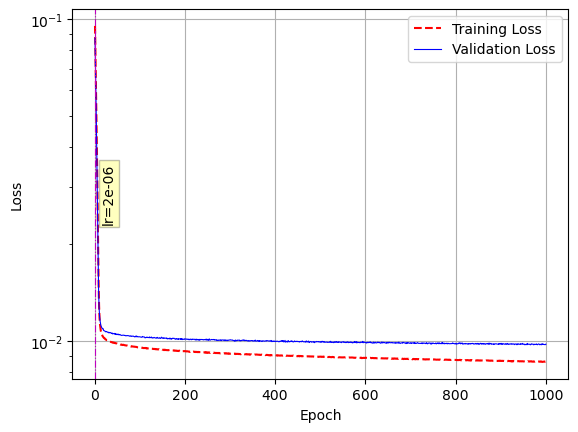

<Figure size 640x480 with 0 Axes>

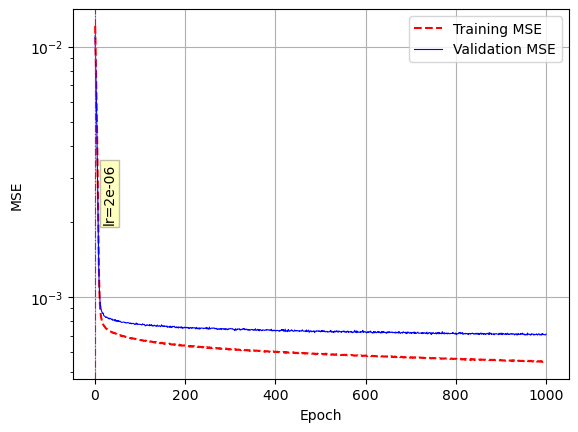

<Figure size 640x480 with 0 Axes>

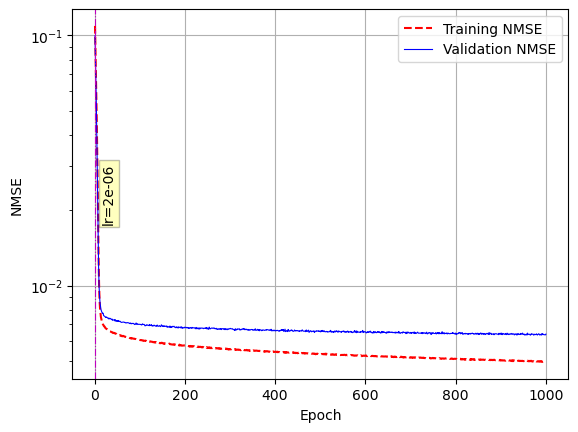

<Figure size 640x480 with 0 Axes>

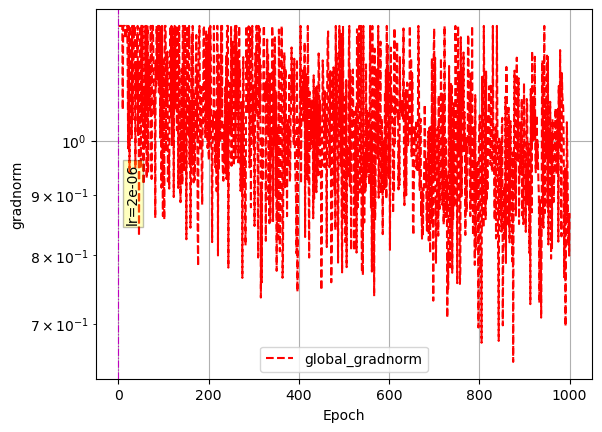

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [23]:
### Training the combined AE-RNN


# 